# ML for currency prediction: USD/CHF 

## Preprocessing 

### Import & load data

In [443]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm 
import random 

import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

df = pd.read_csv("Data/data_daily/dataset_daily.csv")
data = []
for i in df.columns[1:]:
    data.append(df[i])

df.head(4)

Date  Open_USD_CHF  Open_CHF_EUR  Open_CHF_GBP  Open_CHF_JPY  \
0  2001-12-28        1.6776        0.6745        0.4106         78.48   
1  2002-01-04        1.6506        0.6733        0.4210         79.79   
2  2002-01-07        1.6520        0.6760        0.4180         79.26   
3  2002-01-08        1.6480        0.6785        0.4209         79.49   

   Open_CHF_CAD  Open_USD_JPY  Open_USD_EUR  Open_USD_GBP  Open_USD_CAD  \
0        0.9520        131.68        1.1319        0.6887        1.5981   
1        0.9677        131.72        1.1126        0.6953        1.5984   
2        0.9657        130.90        1.1168        0.6906        1.5956   
3        0.9695        131.04        1.1187        0.6940        1.5987   

   Prev_Close_USD_CHF  Prev_Close_BondCH1m  Prev_Close_BondCH2y  \
0              1.6806                 1.68                2.011   
1              1.6500                 1.72                2.059   
2              1.6519                 1.69                1.966   
3              1.6490                 1.65                2.531   

   Prev_Close_BondCH10y  Prev_Close_SMI  Prev_Close_BondUS1m  \
0                 3.460          6410.6                1.751   
1                 3.403          6380.9                1.720   
2                 3.412          6392.9                1.725   
3                 3.401          6384.4                1.700   

   Prev_Close_BondUS2y  Prev_Close_BondUS10y  Prev_Close_SP500  
0                3.307                 5.072            1157.1  
1                3.168                 5.111            1165.3  
2                3.170                 5.125            1172.5  
3                3.053                 5.049            1164.9

### Data distribution 

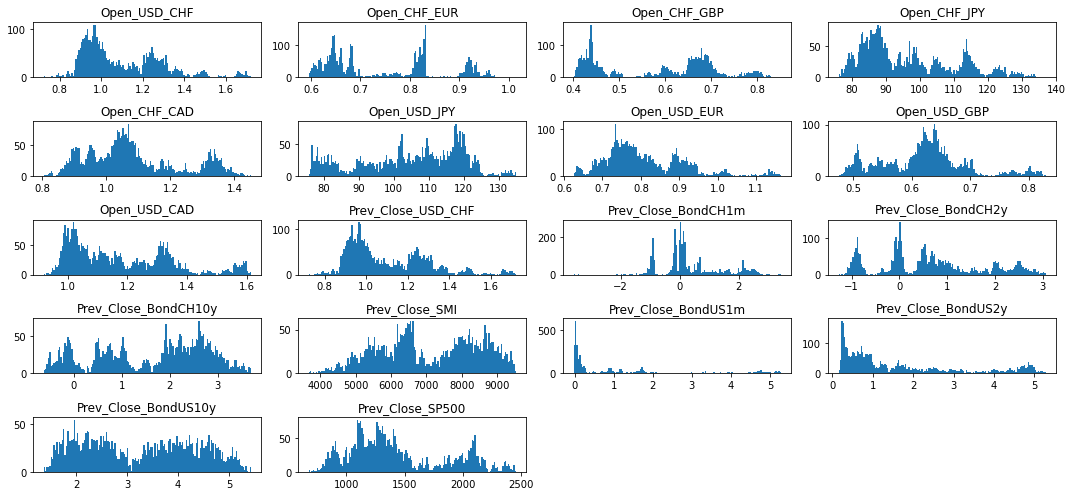

In [28]:
fig = plt.figure(figsize=(15, 7))

name  = df.columns[1:]

for i in range(len(data)):   
    plt.subplot(5, 4,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

### Generate Dataset 

In [444]:
result_price_df = pd.DataFrame(index=['MSE','ACC','MEAN RET %'])
result_trend_df = pd.DataFrame(index=['ACC','MEAN RET %'])

device = 'cpu'
LOOKBACK = 6
span_trend = 4
fraction_val = 0.125
fraction_test = 0.2    

# train_y, val_y, test_y WITH TREND LABEL: 0 or 1.
train_x, val_x, test_x, train_y, val_y, test_y, _, price_tuple= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=True,
  span_trend_=span_trend,
  span_back_trend_= 0,
  norm_=True,
  fraction_val_=fraction_val,
  fraction_test_=fraction_test)

# rain_y_reg, val_y_reg, test_y_reg WITH PRICE LABEL: USD/CHF.
_, _, _, train_y_reg, val_y_reg, test_y_reg, norm, _= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=False,
  span_trend_=span_trend,
  norm_=True,
  fraction_val_=fraction_val,
  fraction_test_=fraction_test)

Number nan: 33 (for var len = 2475)
Number nan: 29 (for var len = 354)
Number nan: 34 (for var len = 709)
Shape:             
X train     (2466, 6, 36), y train     (2466, 18)            
X train val (345, 6, 36) , y train val (345, 18)             
X test      (700, 6, 36) , y test      (700, 18)             
Price       3538
Number nan: 33 (for var len = 2475)
Number nan: 29 (for var len = 354)
Number nan: 34 (for var len = 709)
Shape:             
X train     (2466, 6, 36), y train     (2466, 18)            
X train val (345, 6, 36) , y train val (345, 18)             
X test      (700, 6, 36) , y test      (700, 18)             
Price       3538


In [445]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y_reg[np.isnan(train_y_reg)] = 0.5 
val_y_reg[np.isnan(val_y_reg)] = 0.5
test_y_reg[np.isnan(test_y_reg)] = 0.5

train_y_reg[np.isnan(train_y_reg)] , val_y_reg[np.isnan(val_y_reg)], test_y_reg[np.isnan(test_y_reg)] 

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

In [446]:
buff = train_y[:,0]
positive_weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)
print(positive_weight)

tensor(1.1556)


### Inspect feature 

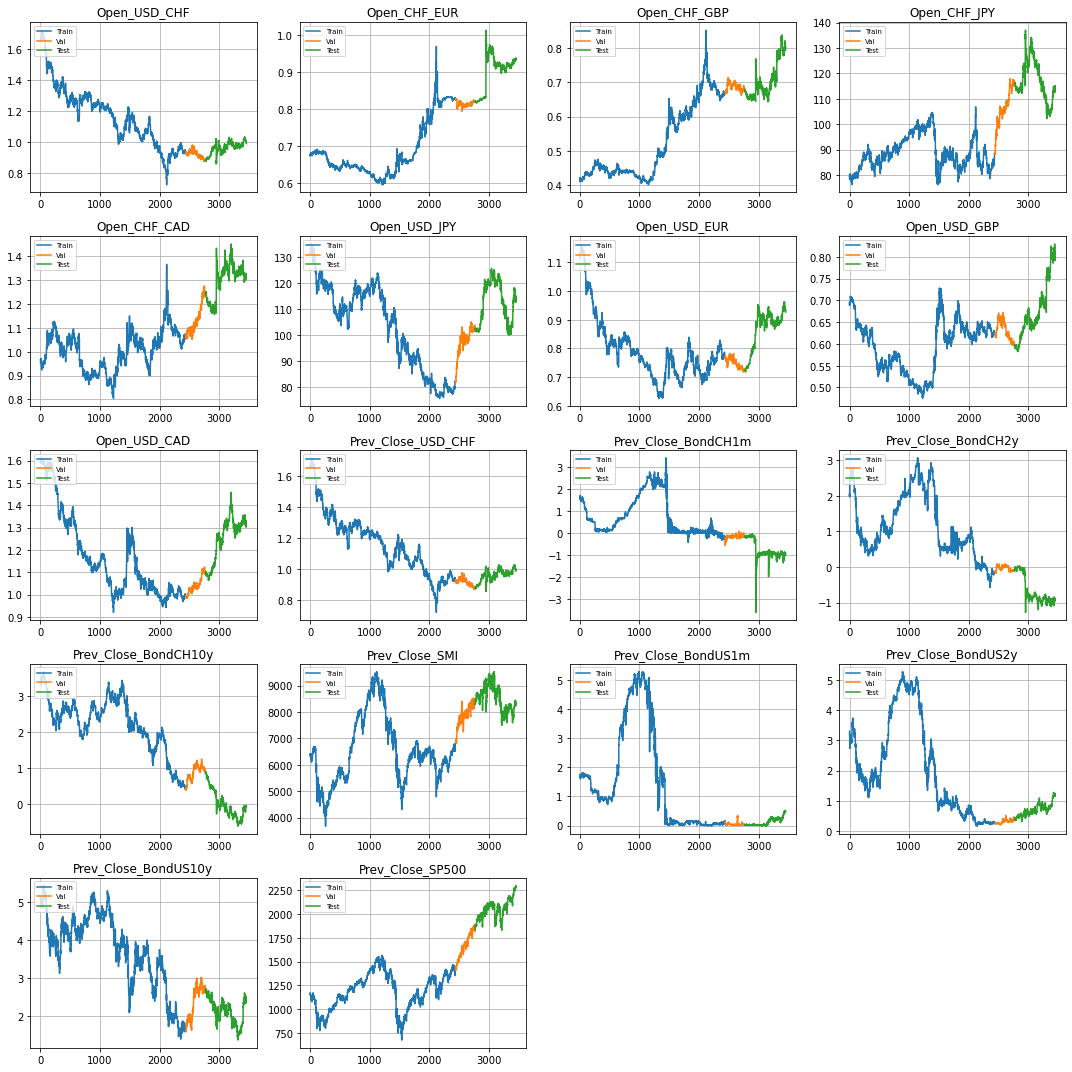

In [234]:
L1 = len(train_x)
L2 = len(val_x) + L1
L3 = len(test_x) + L2 

fig = plt.figure(figsize=(15, 15))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(5, 4,i+1)
  plt.title(name[i])
  plt.plot(np.arange(L1), data[i].iloc[:L1], label='Train')
  plt.plot(np.arange(L1, L2), data[i].iloc[L1:L2], label='Val')
  plt.plot(np.arange(L2,L3), data[i].iloc[L2:L3], label='Test')
  plt.grid()
  plt.legend(loc='upper left', fontsize=7)

plt.tight_layout()
plt.savefig("featurs.svg")
plt.show()

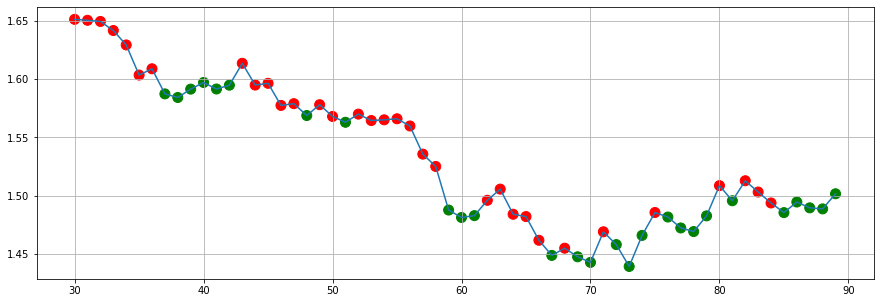

In [235]:
# TRAIN DATA
end = 90
start = 30

colors = {0:'red', 1:'green'}
plt.figure(figsize=(15,5))
scatter = plt.scatter(np.arange(start, end), price_tuple[0][start:end ], c=pd.Series(train_y[start:end,0]).map(colors).values, s=100)
plt.plot(np.arange(start, end), price_tuple[0][start: end ])

plt.grid()
plt.savefig("trend_prediction.svg")
plt.show()

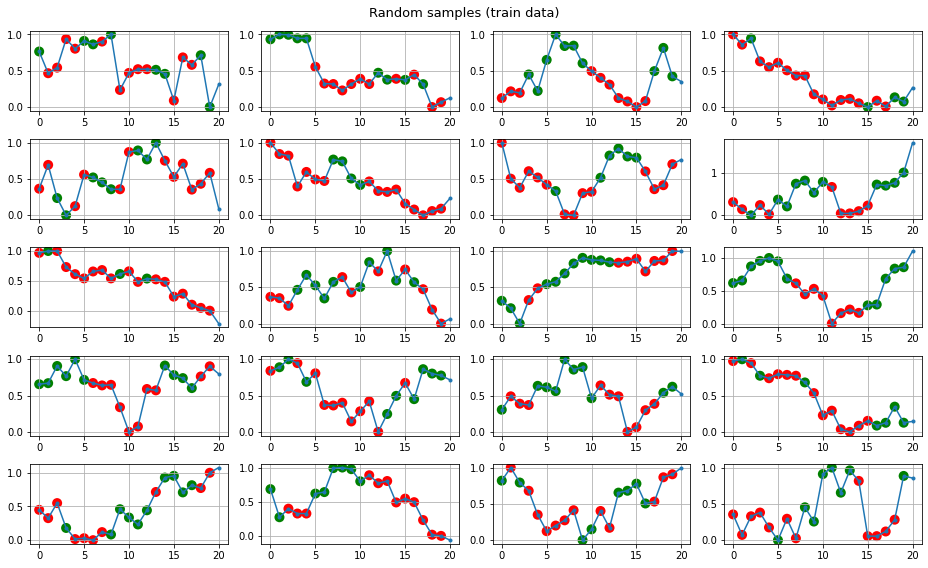

In [236]:
plt.figure(figsize=(13,8))
plt.suptitle("Random samples (train data)", fontsize=13)
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, train_x.shape[0]-1)
        colors = {0:'red', 1:'green'}
        all_series= np.concatenate((train_x[idx,:,0].reshape(-1,),train_y_reg[idx,0].reshape(-1,)))
        plt.scatter(np.arange(0,train_x.shape[1]), all_series[:-1], c=pd.Series( train_x[idx, :, 1]).map(colors).values, s=100, lw=0)
        ax.plot(all_series, '.-')
        ax.grid()
plt.tight_layout()
plt.show()

###

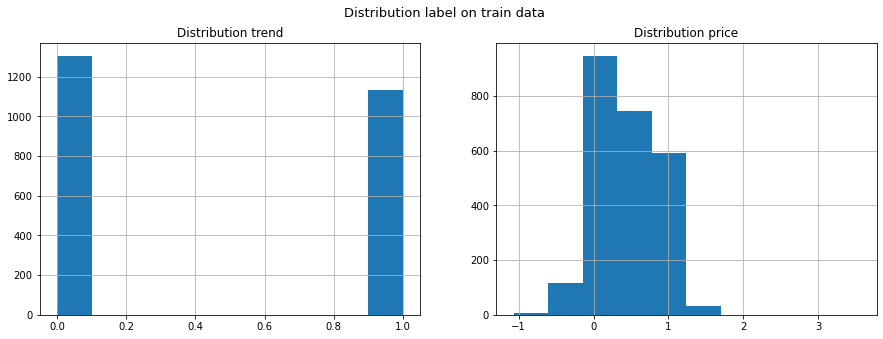

In [237]:
plt.figure(figsize=(15,5))
plt.suptitle("Distribution label on train data", fontsize=13)
plt.subplot(1,2,1)
plt.hist(train_y[:,0], )
plt.title("Distribution trend")
plt.grid()
plt.subplot(1,2,2)
plt.hist(train_y_reg[:,0], )
plt.title("Distribution price")
plt.grid()
plt.savefig("dist.svg")
plt.show()

## Model

### Auto-Encoder

#### Auto-Encoder Model

In [454]:
AE = ml.ResUNet()
AE.to(device)
AE

ResUNet(
  (conv): Conv1d(36, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (block1): Sequential(
    (0): ResBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ResBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
   

  7%|▋         | 328/5000 [07:39<1:49:05,  1.40s/it]

0.003609633785672486 < 0.003610212579369545
Epoch: 329/5000
MSE = [train loss mean :  0.01015639] , [val loss mean:  0.01249192, MSE (last) 0.37624%]


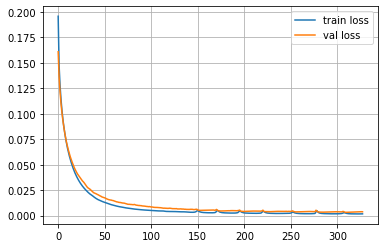

In [455]:
lr= 0.001
num_epochs= 5000

train_loss, val_loss = pl.train(
    model=AE,
    train_x_ = np.swapaxes(train_x,1,2),
    train_y_ =  np.swapaxes(train_x,1,2),
    val_x_ = np.swapaxes(val_x,1,2),
    val_y_=  np.swapaxes(val_x,1,2),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1 #int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() #4.77938% 0.14284399


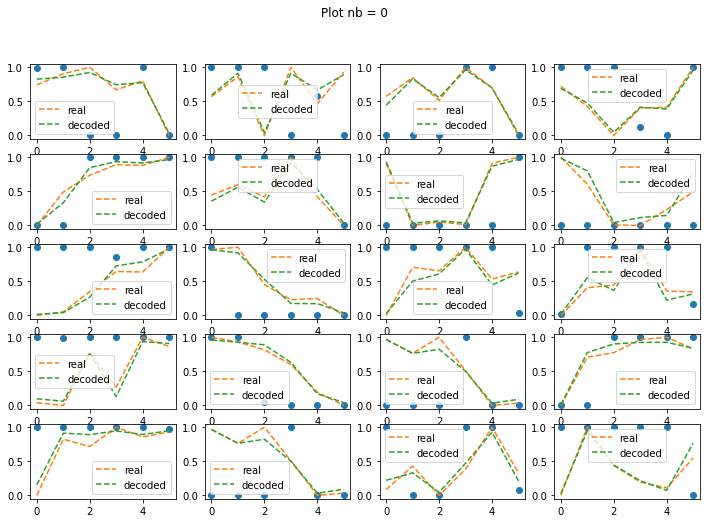

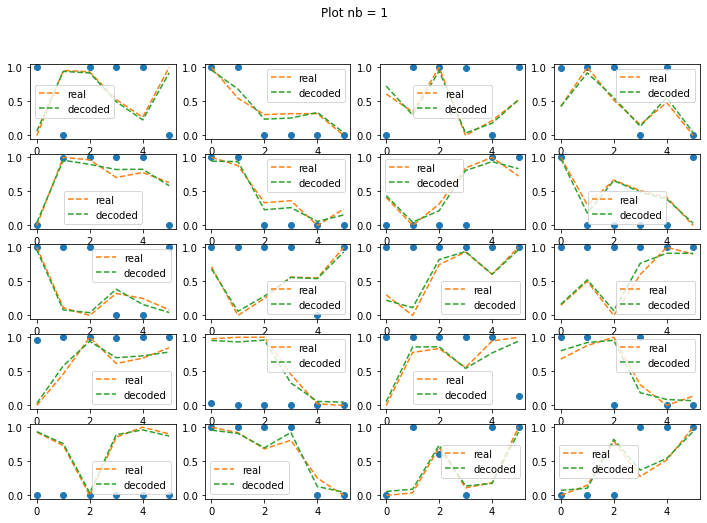

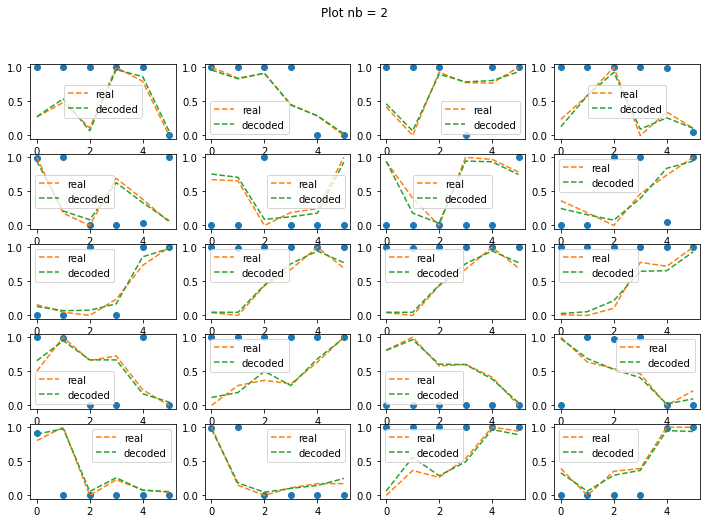

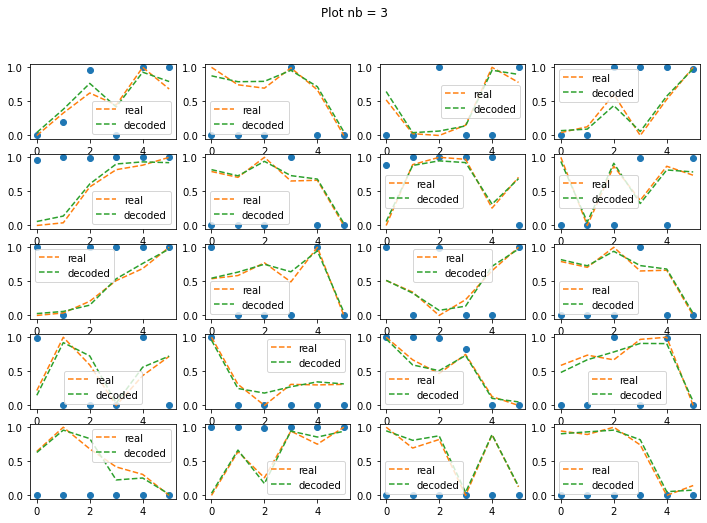

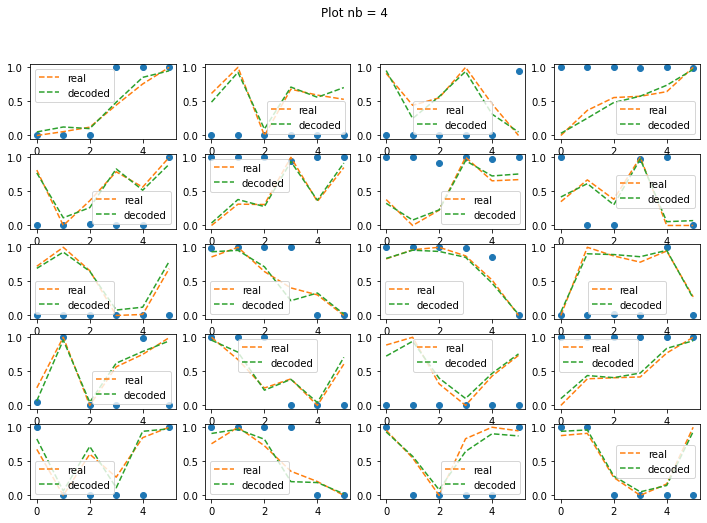

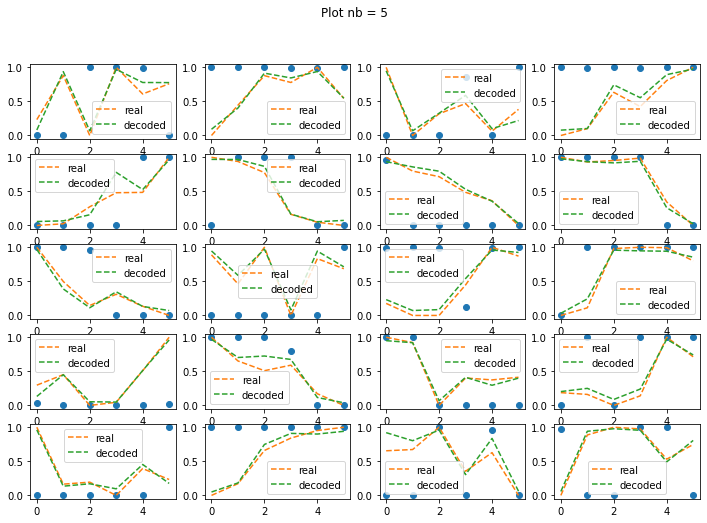

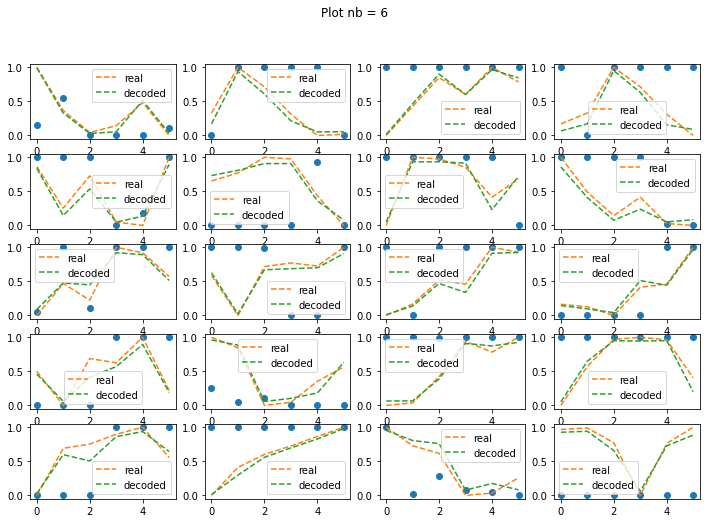

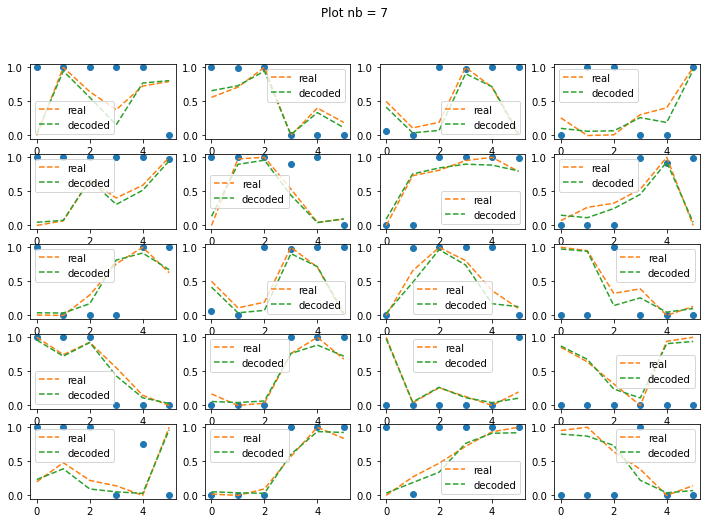

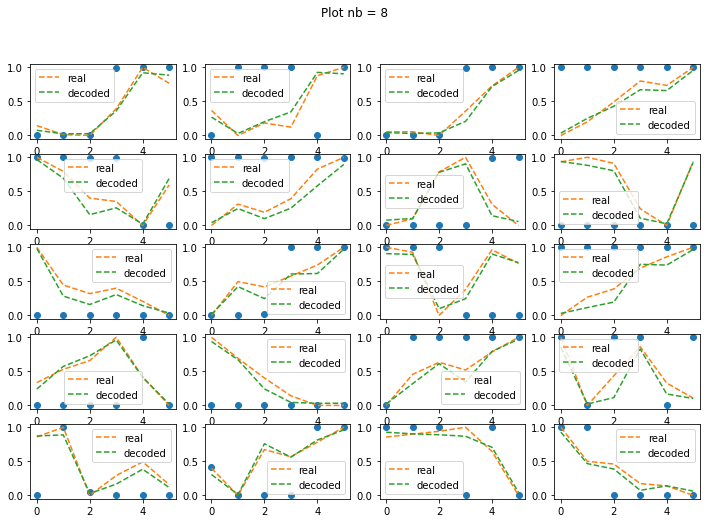

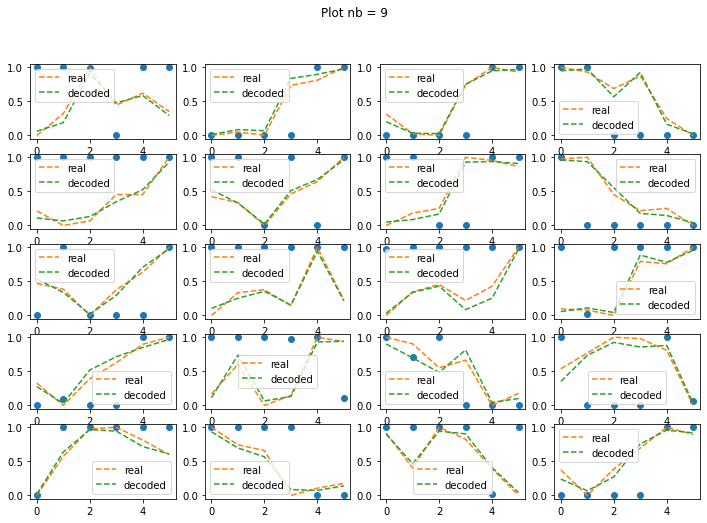

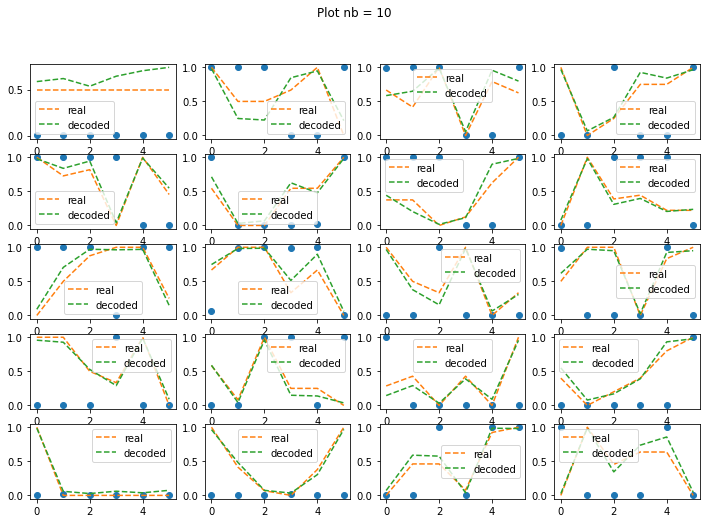

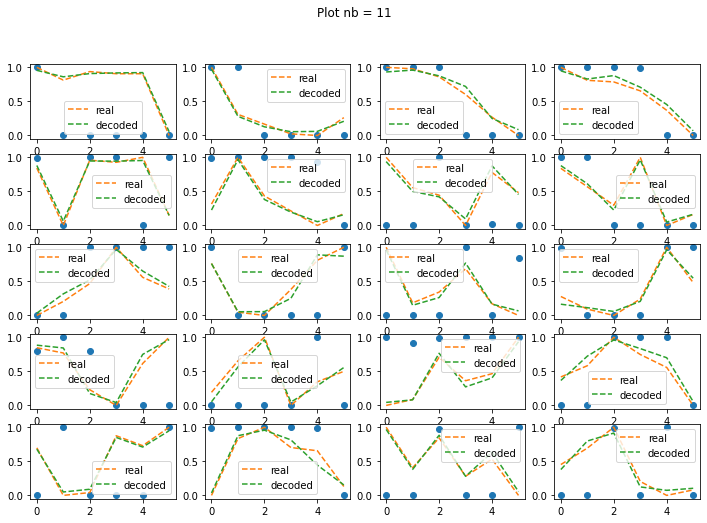

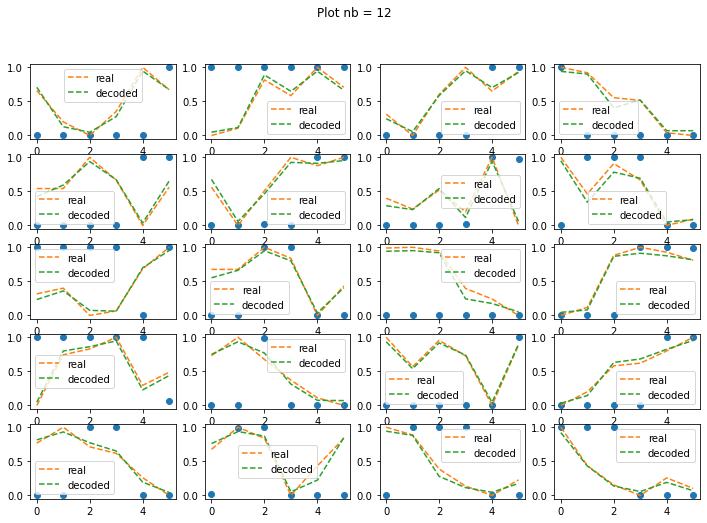

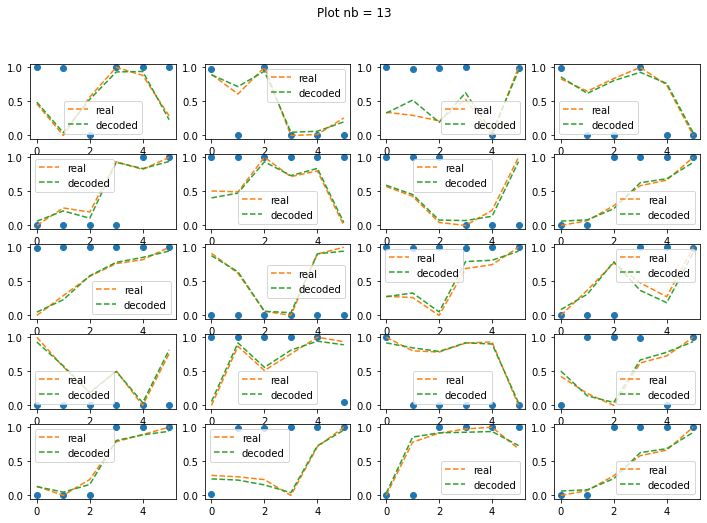

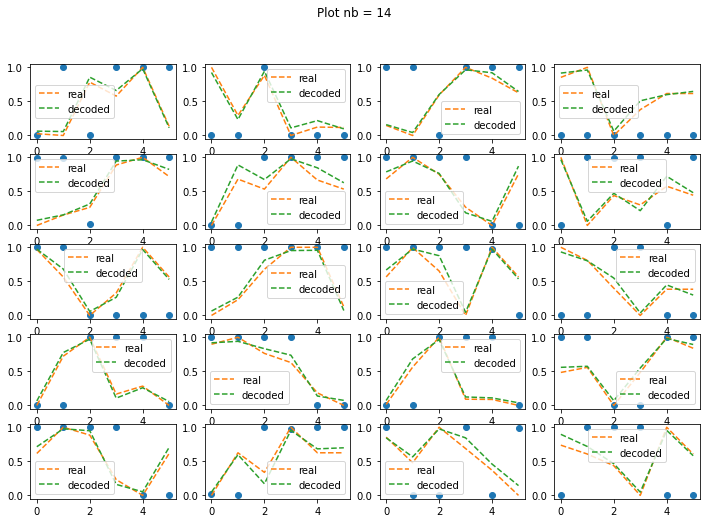

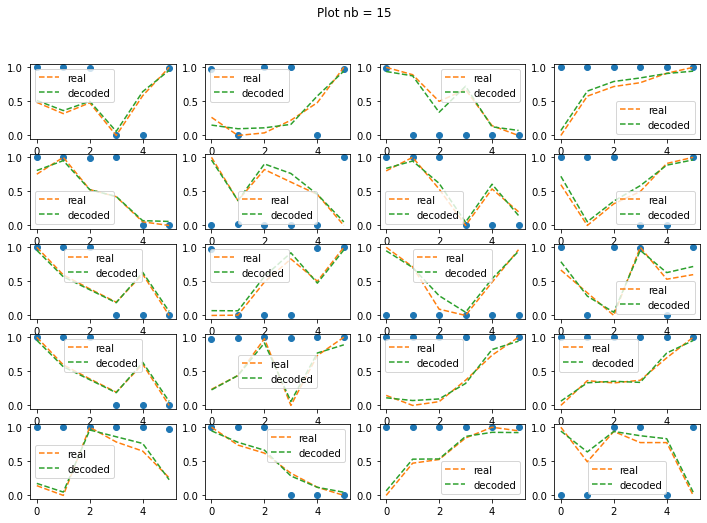

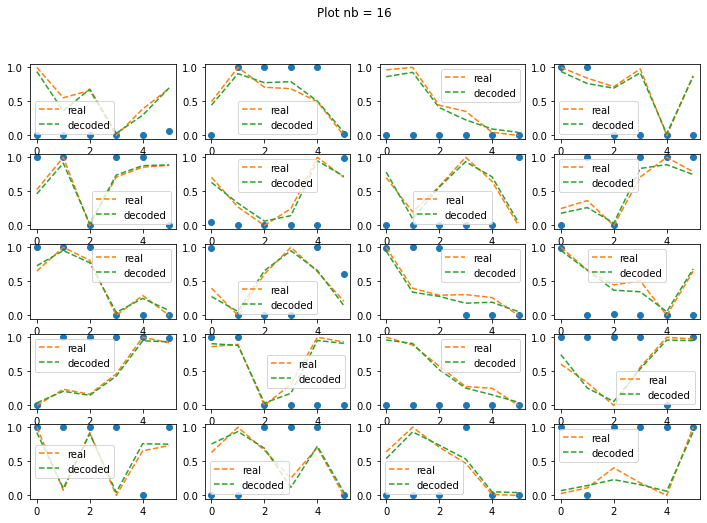

In [456]:
outputs_autoenc, targets, MSE = pl.evaluate(AE, np.swapaxes(test_x,1,2), np.swapaxes(test_x,1,2), device='cpu') 

for p in range(17):
    plt.figure(figsize=(12,8))
    plt.suptitle("Plot nb = " + str(p))
    plots = []
    for i in range(5):
        for j in range(4):
            ax = plt.subplot2grid((5,4), (i,j))
            idx = random.randint(0, test_x.shape[0]-1)
           
            ax.plot(outputs_autoenc[idx,p*2+1,:], 'o')
            ax.plot(test_x[idx,:,p*2], '--', label= "real")
            ax.plot(outputs_autoenc[idx,p*2,:], '--', label= "decoded")

            #ax.plot(test_x[idx,:,0], '--', label= "real")
            #ax.plot(outputs_autoenc[idx, 0, :], '-o', label = "decoded")
            ax.legend()
    plt.show() 

In [460]:
torch.save(AE.cpu().state_dict(), 'Helper/model/model_AutoEncoder.pth')


#### Apply Auto-Encoder to the dataset 

In [461]:
AE = ml.ResUNet()
AE.load_state_dict(torch.load('Helper/model/model_AutoEncoder.pth'))
AE.to(device)
AE

ResUNet(
  (conv): Conv1d(36, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (block1): Sequential(
    (0): ResBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ResBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
   

In [462]:
model_AutoEncoder.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out = model_AutoEncoder(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_AutoEncoder(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp3 = torch.from_numpy(np.swapaxes(test_x,1,2))
out = model_AutoEncoder(inp3.to(device).float())
test_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

### Price prediction

#### Baseline

##### Dense

In [184]:
model_Dense = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense.to(device)
model_Dense

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 16%|█▋        | 163/1000 [00:27<02:21,  5.93it/s]


0.1628708642721176 < 0.16307226181030274
Epoch: 164/1000
MSE = [train loss mean :  0.26107988] , [val loss mean:  0.19746532, MSE (last) 17.07020%]


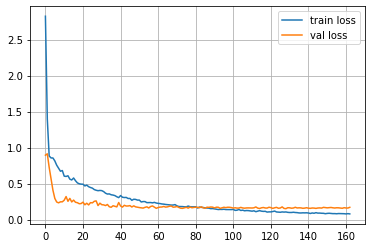

In [185]:
lr= 0.001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense,
    train_x_ = train_x.reshape(train_x.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x.reshape(val_x.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize = 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 


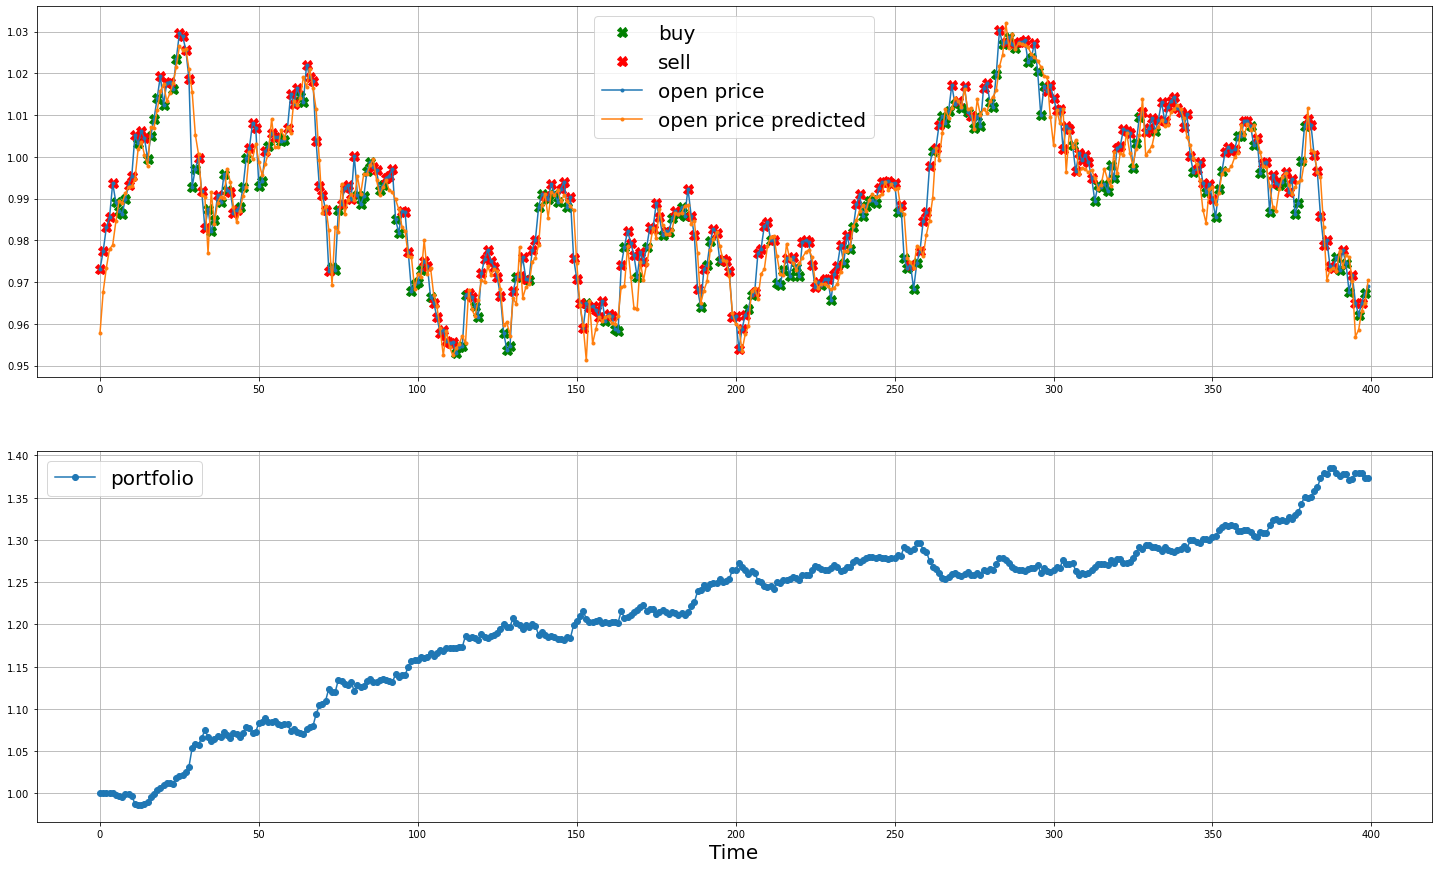

37.36065031231506


MSE           0.000092
ACC           0.668091
MEAN RET %    0.080301
Name: Dense, dtype: float64

In [186]:
outputs_Dense, targets, MSE = pl.evaluate(model_Dense, test_x.reshape(test_x.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense = pp.min_max_norm_inverse(outputs_Dense.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense = np.mean((outputs_Dense-t)**2)
ACC_Dense = pl.direction_accuracy(outputs_Dense, t)
MEAN_RET_Dense = pl.evauate_strategy(t, outputs_Dense, plot=True)

result_price_df['Dense'] = [MSE_Dense, ACC_Dense, MEAN_RET_Dense]
result_price_df['Dense']

##### LSTM

In [400]:
model_LSTM = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM.to(device)
model_LSTM

LSTM_base(
  (lstm): LSTM(34, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 202/1000 [00:15<01:01, 12.89it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.65326598] , [val loss mean:  0.72205976, MSE (last) 28.17348%]


 40%|████      | 402/1000 [00:31<00:49, 11.99it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.23812865] , [val loss mean:  0.23291094, MSE (last) 21.06838%]


 60%|██████    | 602/1000 [00:47<00:30, 13.12it/s]

Epoch: 600/1000
MSE = [train loss mean :  0.19493510] , [val loss mean:  0.20303343, MSE (last) 19.66312%]


 66%|██████▌   | 657/1000 [00:51<00:27, 12.69it/s]


0.19573994040489195 < 0.19578600227832793
Epoch: 658/1000
MSE = [train loss mean :  0.18668699] , [val loss mean:  0.19926902, MSE (last) 19.62411%]


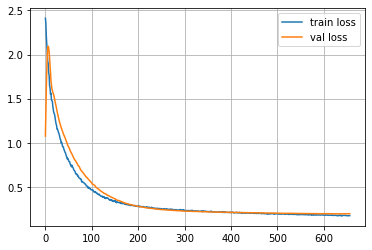

In [401]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM,
    train_x_ = train_x,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 


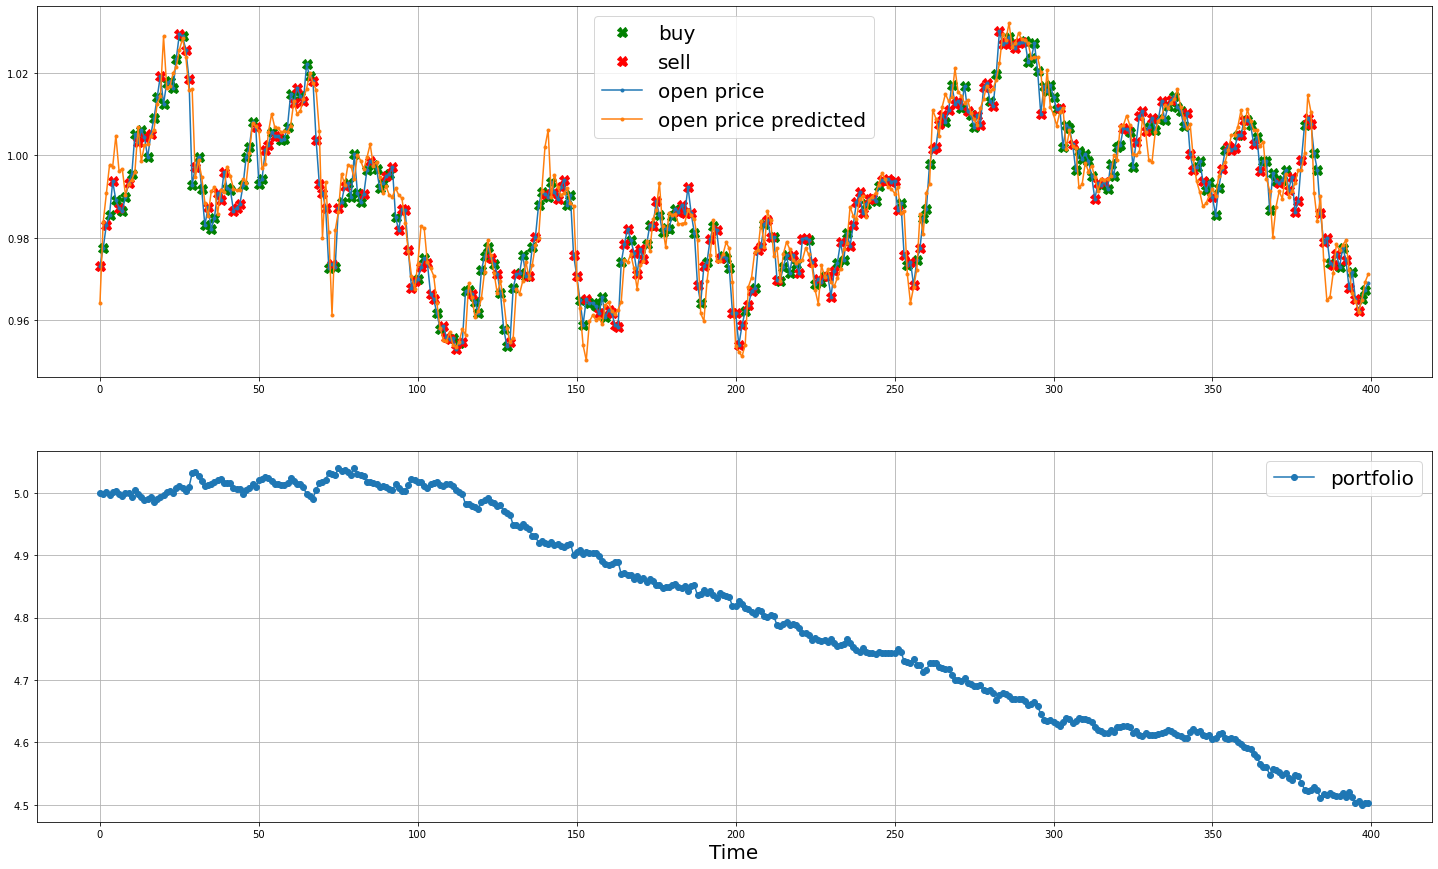

gain = -9.96%


MSE           0.000088
ACC           0.693732
MEAN RET %   -0.026222
Name: LSTM, dtype: float64

In [402]:
outputs_LSTM, targets, MSE = pl.evaluate(model_LSTM, test_x, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM = pp.min_max_norm_inverse(outputs_LSTM.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM = np.mean((outputs_LSTM-t)**2)
ACC_LSTM = pl.direction_accuracy(outputs_LSTM, t)
MEAN_RET_LSTM = pl.evauate_strategy(t, outputs_LSTM, plot=True)

result_price_df['LSTM'] = [MSE_LSTM, ACC_LSTM, MEAN_RET_LSTM]
result_price_df['LSTM']

##### GRU 

In [190]:
model_GRU = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU.to(device)
model_GRU

GRU_base(
  (gru): GRU(34, 32, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:24<01:34,  8.41it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.33230473] , [val loss mean:  0.32820907, MSE (last) 20.25159%]


 38%|███▊      | 382/1000 [00:46<01:15,  8.23it/s]


0.18772540748119354 < 0.18772587418556214
Epoch: 383/1000
MSE = [train loss mean :  0.15913153] , [val loss mean:  0.19287012, MSE (last) 18.79151%]


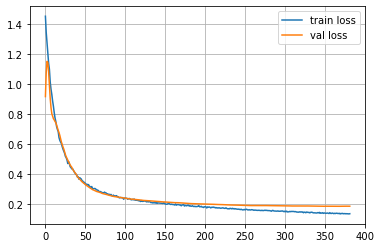

In [191]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU,
    train_x_ = train_x,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

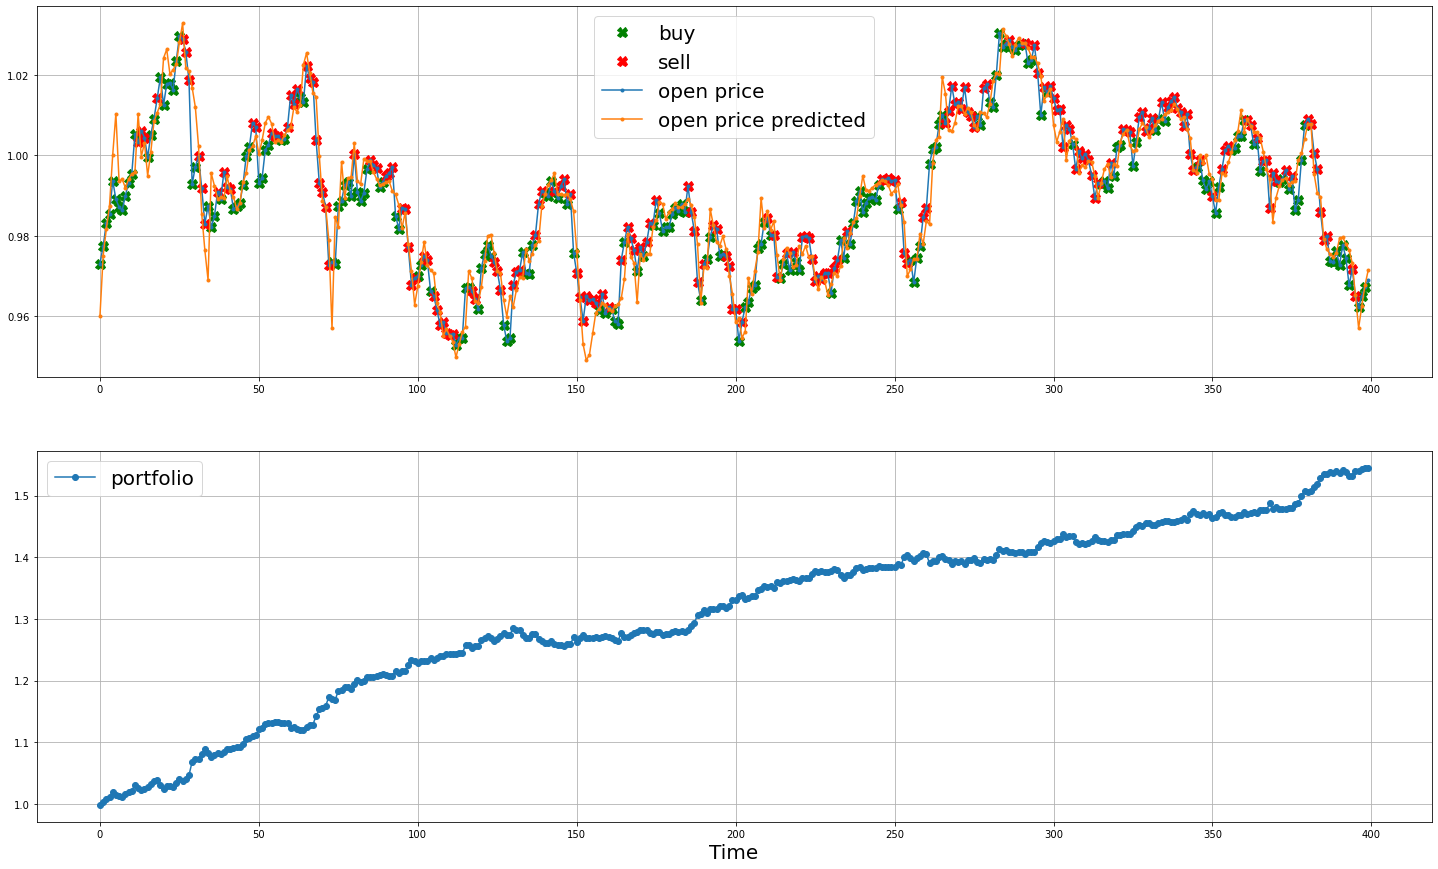

54.703883887655365


MSE           0.000171
ACC           0.716524
MEAN RET %    0.110061
Name: GRU, dtype: float64

In [193]:
outputs_GRU, targets, MSE = pl.evaluate(model_GRU, test_x, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU = pp.min_max_norm_inverse(outputs_GRU.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU = np.mean((outputs_GRU-t)**2)
ACC_GRU = pl.direction_accuracy(outputs_GRU, t)
MEAN_RET_GRU = pl.evauate_strategy(t, outputs_GRU, plot=True)

result_price_df['GRU'] = [MSE_GRU, ACC_GRU, MEAN_RET_GRU]
result_price_df['GRU']

#### Add Auto-Encoder 

##### Dense + AE

In [385]:
model_Dense_AE = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_AE.to(device)
model_Dense_AE

Dense(
  (net): Sequential(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 20%|██        | 201/1000 [00:30<01:59,  6.70it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.57044422] , [val loss mean:  0.23173280, MSE (last) 18.87156%]


 40%|████      | 401/1000 [01:00<01:29,  6.67it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.30972790] , [val loss mean:  0.17860173, MSE (last) 17.23938%]


 43%|████▎     | 426/1000 [01:04<01:26,  6.61it/s]


0.17317660957574843 < 0.17318033933639526
Epoch: 427/1000
MSE = [train loss mean :  0.29500483] , [val loss mean:  0.17671403, MSE (last) 17.41364%]


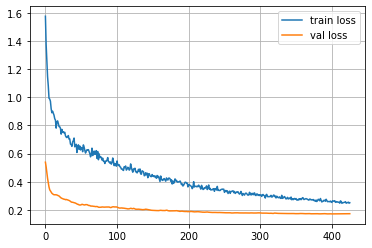

In [386]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_AE,
    train_x_ = train_x_smooth.reshape(train_x_smooth.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x_smooth.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

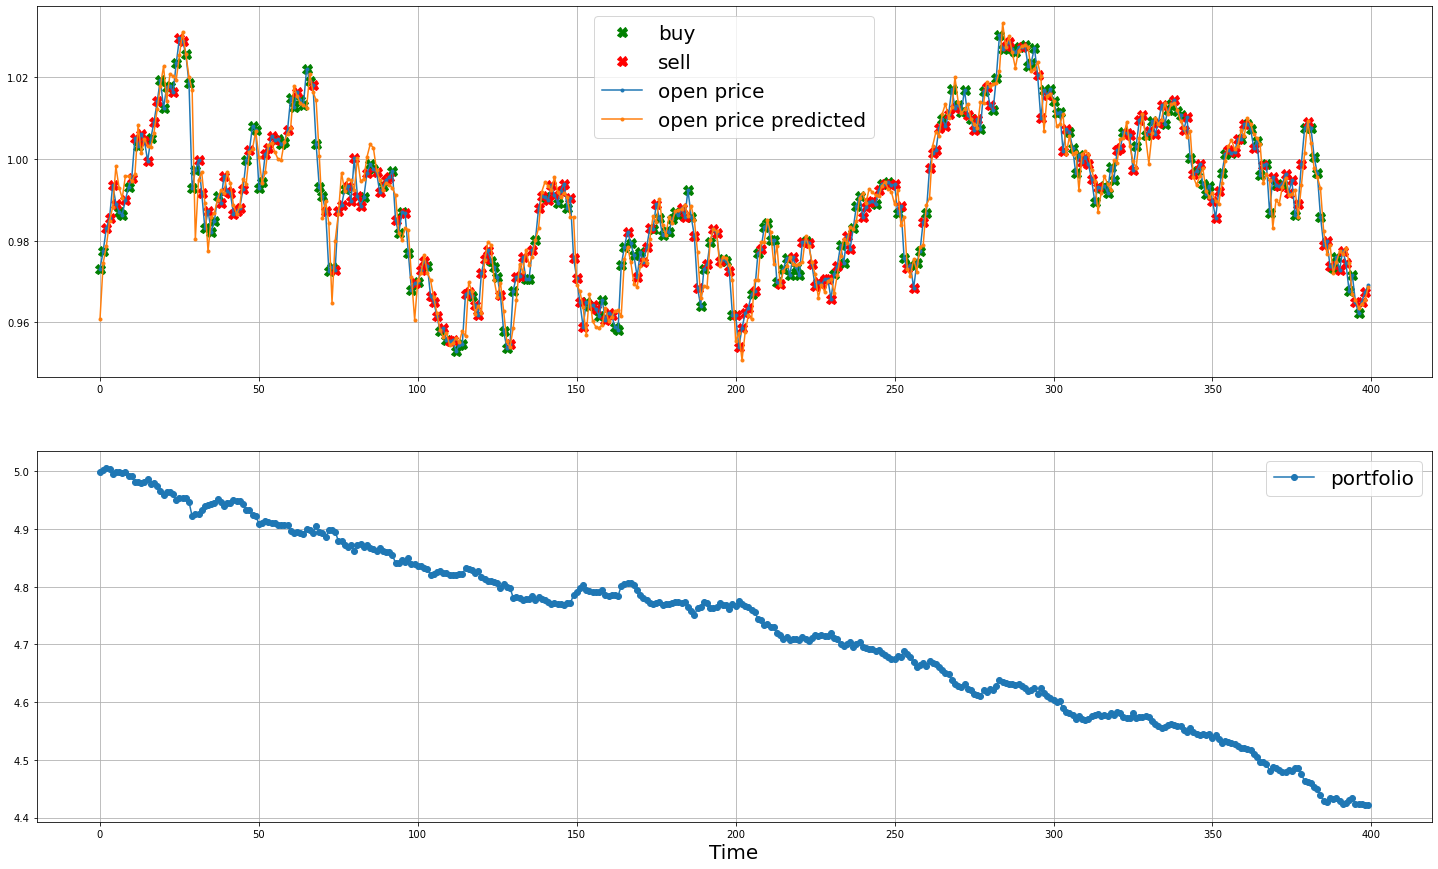

gain = -11.54%


MSE           0.000123
ACC           0.682336
MEAN RET %   -0.030661
Name: Dense_AE, dtype: float64

In [387]:
outputs_Dense_AE, targets, MSE = pl.evaluate(model_Dense_AE, test_x_smooth.reshape(test_x_smooth.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense_AE = pp.min_max_norm_inverse(outputs_Dense_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense_AE = np.mean((outputs_Dense_AE-t)**2)
ACC_Dense_AE = pl.direction_accuracy(outputs_Dense_AE, t)
MEAN_RET_Dense_AE = pl.evauate_strategy(t, outputs_Dense_AE, plot=True)

result_price_df['Dense_AE'] = [MSE_Dense_AE, ACC_Dense_AE, MEAN_RET_Dense_AE]
result_price_df['Dense_AE']

##### LSTM + AE

In [130]:
model_LSTM_AE = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.1,
        device=device)
model_LSTM_AE.to(device)
model_LSTM_AE

LSTM_base(
  (lstm): LSTM(34, 16, num_layers=2, batch_first=True, dropout=0.1)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:28<01:50,  7.22it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.37359491] , [val loss mean:  0.30509255, MSE (last) 18.76636%]


 40%|████      | 401/1000 [00:56<01:22,  7.24it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.23758451] , [val loss mean:  0.18223469, MSE (last) 17.92402%]


 41%|████▏     | 413/1000 [00:58<01:22,  7.11it/s]


0.17925145834684372 < 0.17925586819648742
Epoch: 414/1000
MSE = [train loss mean :  0.23667534] , [val loss mean:  0.18171409, MSE (last) 18.08744%]


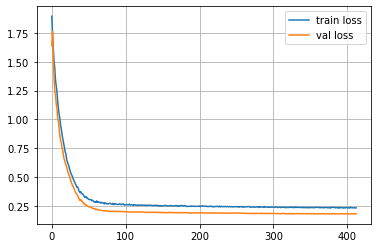

In [131]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_AE,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=128,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

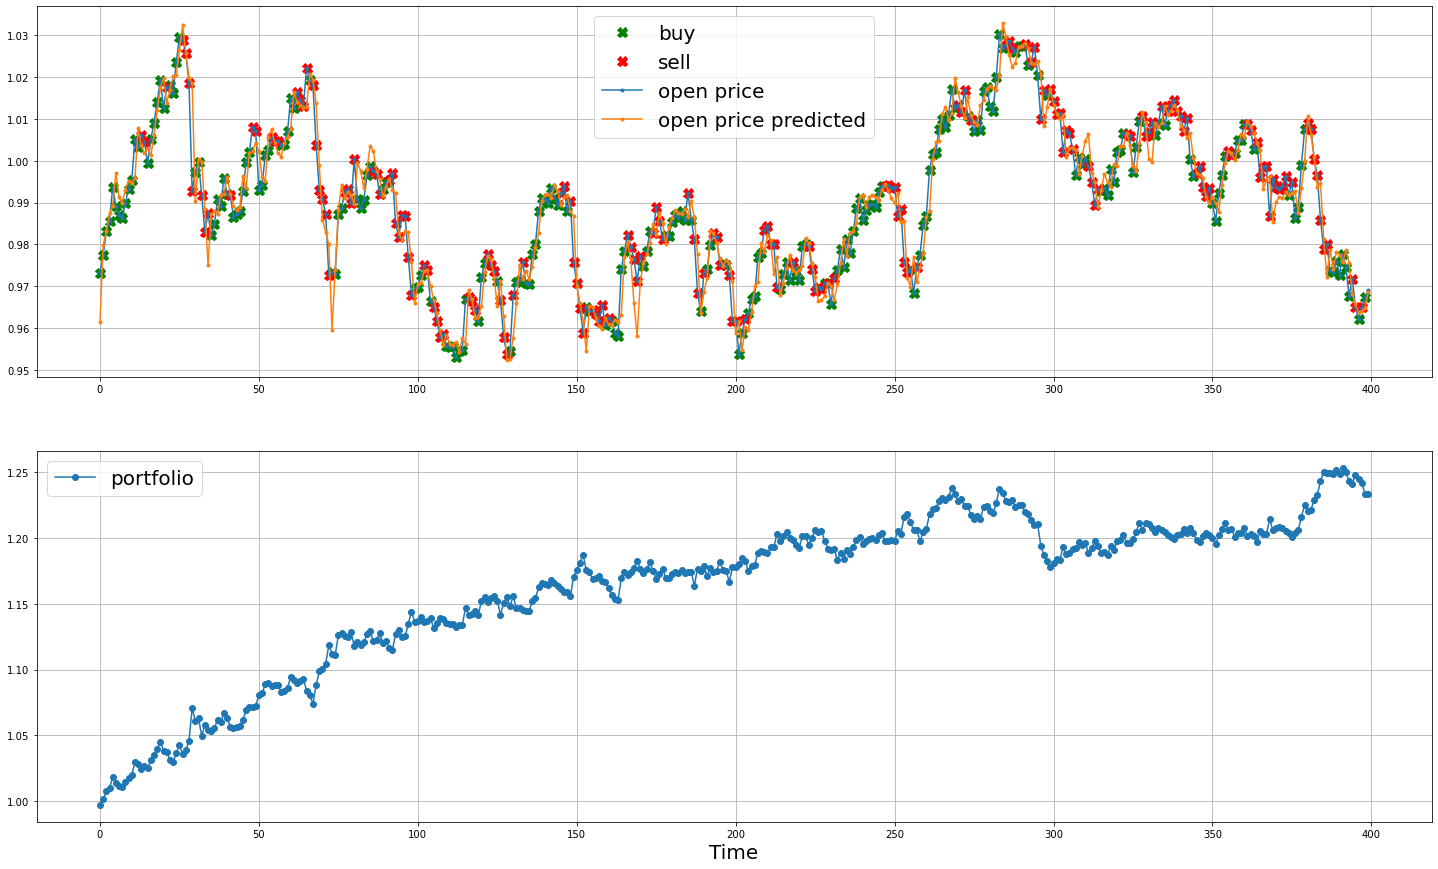

gain = 23.74%


MSE           0.000124
ACC           0.690883
MEAN RET %    0.054474
Name: LSTM_AE, dtype: float64

In [132]:
outputs_LSTM_AE, targets, MSE = pl.evaluate(model_LSTM_AE, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM_AE = pp.min_max_norm_inverse(outputs_LSTM_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM_AE = np.mean((outputs_LSTM_AE-t)**2)
ACC_LSTM_AE = pl.direction_accuracy(outputs_LSTM_AE, t)
MEAN_RET_LSTM_AE = pl.evauate_strategy(t, outputs_LSTM_AE, start=300, end=700, plot=True, tax=0.997)

result_price_df['LSTM_AE'] = [MSE_LSTM_AE, ACC_LSTM_AE, MEAN_RET_LSTM_AE]
result_price_df['LSTM_AE']

##### GRU + AE

In [235]:
model_GRU_AE = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.1,
        device=device)
model_GRU_AE.to(device)
model_GRU_AE

GRU_base(
  (gru): GRU(34, 16, num_layers=2, batch_first=True, dropout=0.1)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 202/1000 [00:13<00:51, 15.64it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.40034561] , [val loss mean:  0.28886775, MSE (last) 20.70231%]


 40%|████      | 402/1000 [00:26<00:38, 15.59it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.24464373] , [val loss mean:  0.19212669, MSE (last) 18.22638%]


 50%|█████     | 503/1000 [00:32<00:32, 15.29it/s]


0.18046169370412826 < 0.18047403395175934
Epoch: 504/1000
MSE = [train loss mean :  0.23003367] , [val loss mean:  0.18315183, MSE (last) 18.04733%]


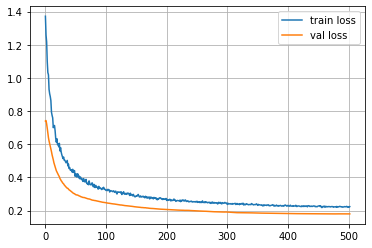

In [236]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_AE,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

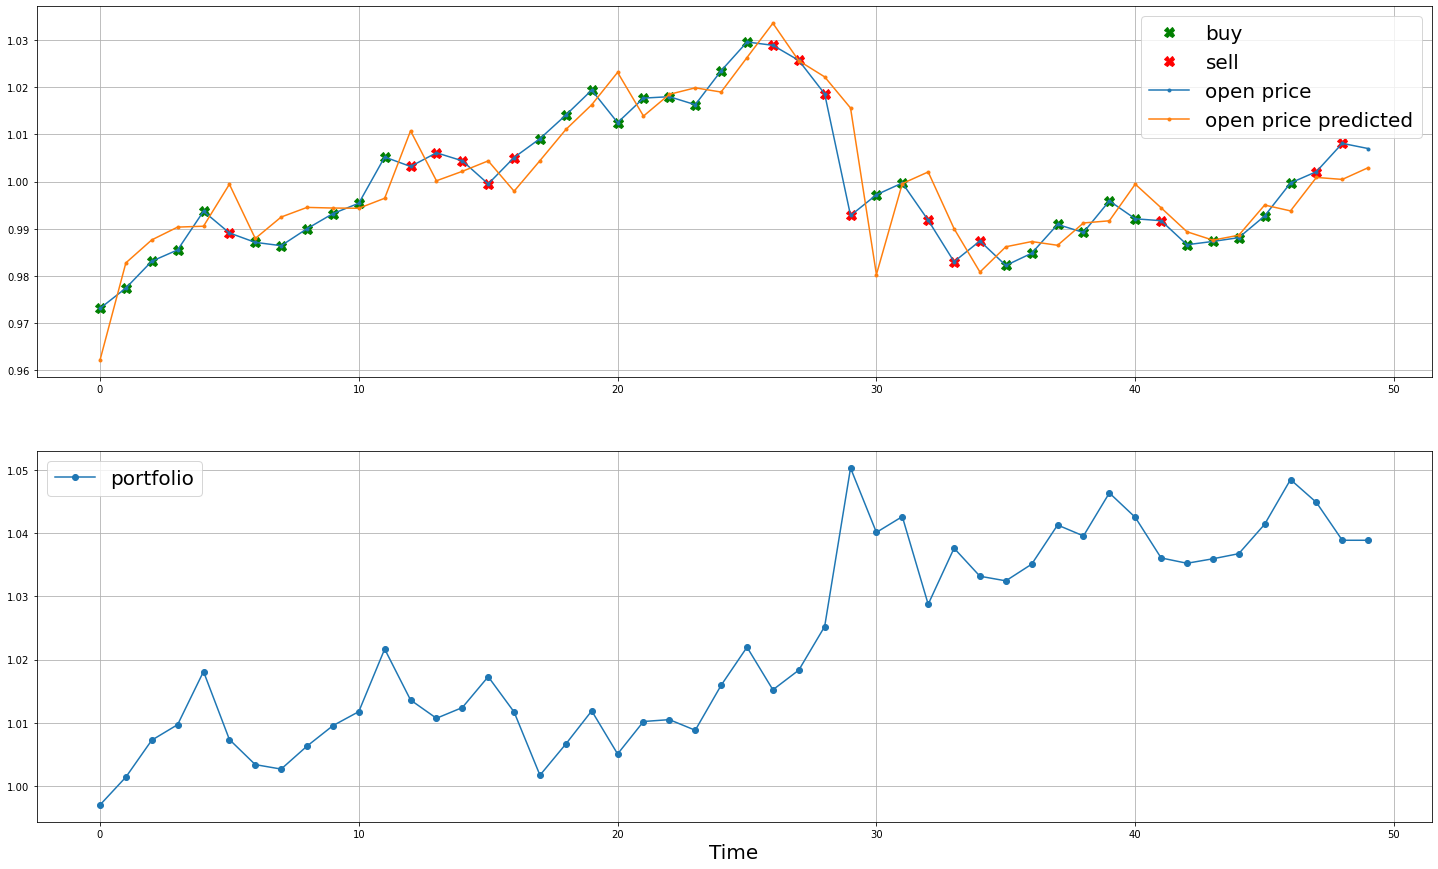

gain = 4.20%


MSE           0.000137
ACC           0.692308
MEAN RET %    0.086131
Name: GRU_AE, dtype: float64

In [331]:
outputs_GRU_AE, targets, MSE = pl.evaluate(model_GRU_AE, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU_AE = pp.min_max_norm_inverse(outputs_GRU_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU_AE = np.mean((outputs_GRU_AE-t)**2)
ACC_GRU_AE = pl.direction_accuracy(outputs_GRU_AE, t)
MEAN_RET_GRU_AE = pl.evauate_strategy(t, outputs_GRU_AE, plot=True,start = 300, end=350, tax=0.997)

result_price_df['GRU_AE'] = [MSE_GRU_AE, ACC_GRU_AE, MEAN_RET_GRU_AE]
result_price_df['GRU_AE']

In [341]:
price = t[1:]
pred = t[:-1] 

In [351]:
np.random.rand((1))

array([0.70358176])

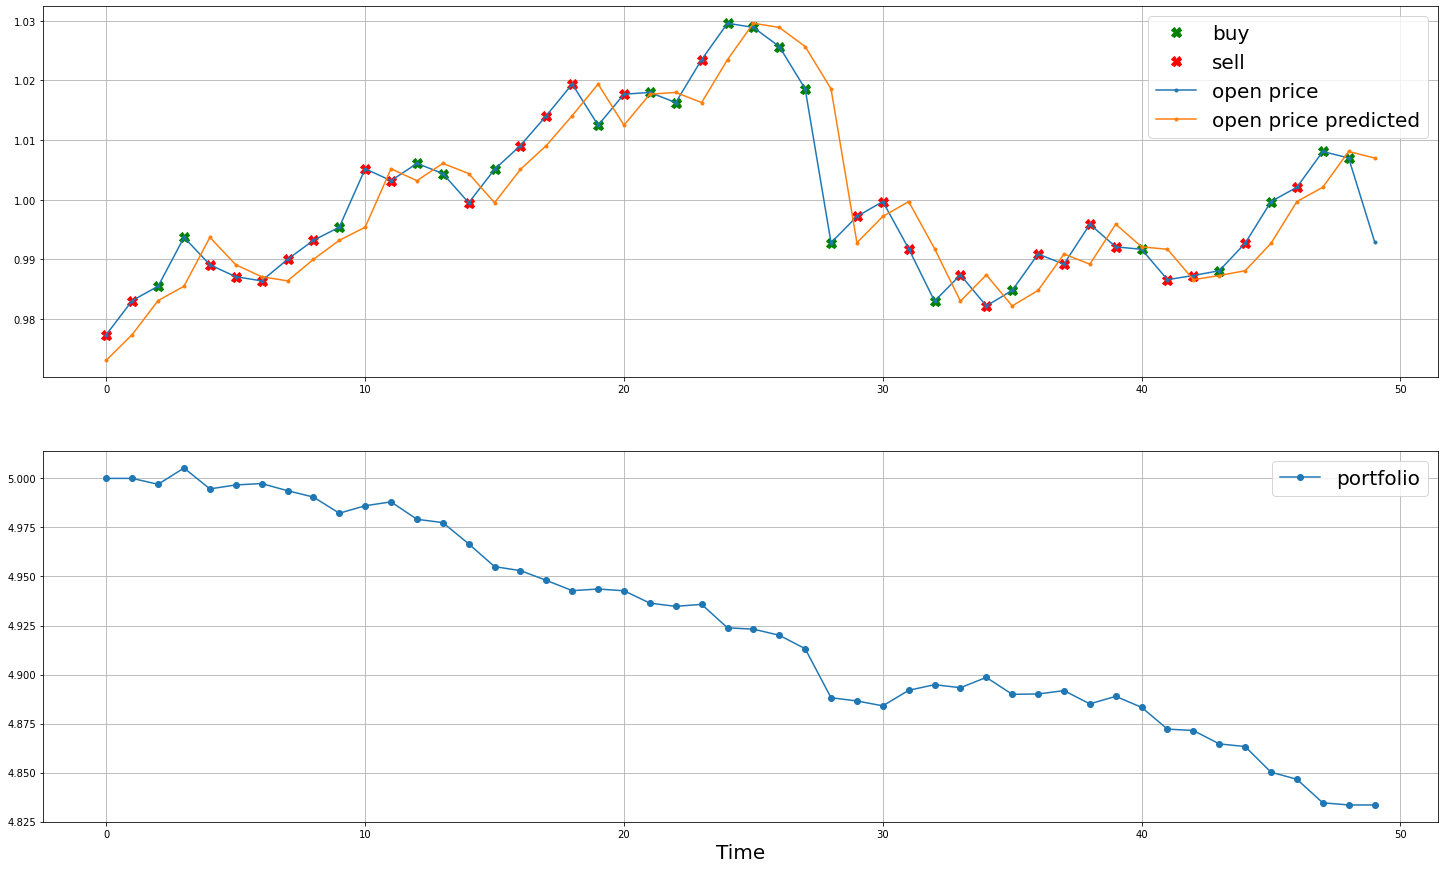

gain = -3.33%


-0.06900555389499834

In [358]:
pl.evauate_strategy(price, pred, plot=True,start = 300, end=350, tax=0.997)

#### Add Regularized Loss: $L = \sum (y- \hat{y})^2 + \lambda \sum ((y- y_{prev})(y- \hat{y}))^2 $

##### Dense + AE + REG

In [240]:
model_Dense_AE_REG = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_AE_REG.to(device)
model_Dense_AE_REG

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 14%|█▎        | 135/1000 [00:22<02:22,  6.09it/s]


0.18123708615357847 < 0.18132852795480311
Epoch: 136/1000
MSE = [train loss mean :  0.60999973] , [val loss mean:  0.21427455, MSE (last) 6317.44995%]


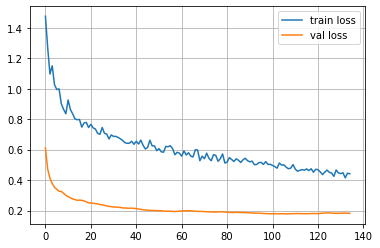

In [241]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_Dense_AE_REG,
    train_x_ = train_x_smooth.reshape(train_x_smooth.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x_smooth.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lambda_=0.01,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show()

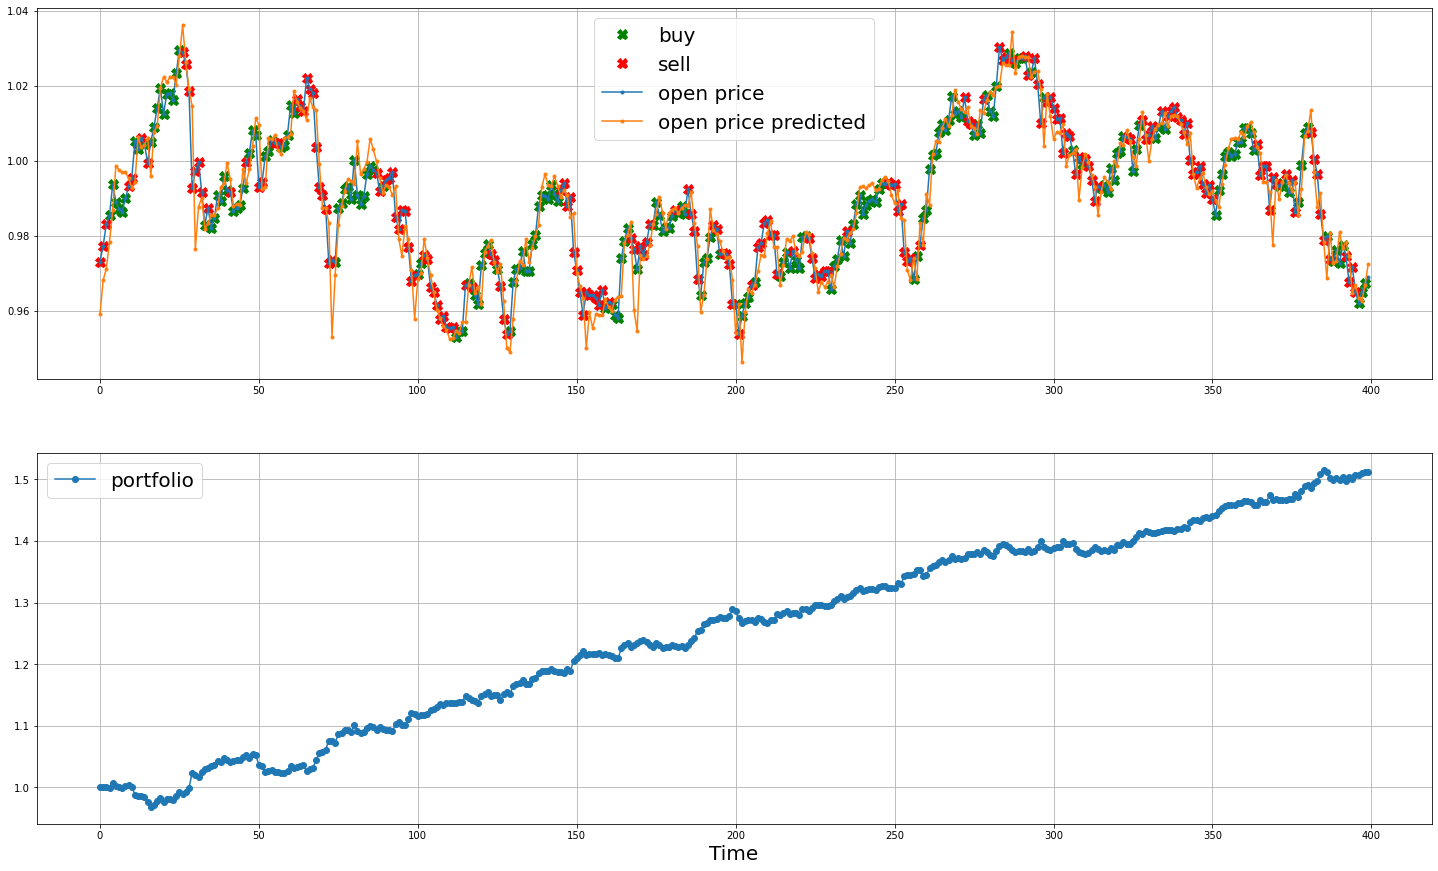

gain = 51.25%


MSE           0.000120
ACC           0.650997
MEAN RET %    0.104628
Name: Dense_AE_REG, dtype: float64

In [242]:

outputs_Dense_AE_REG, targets, MSE = pl.evaluate(model_Dense_AE_REG, test_x_smooth.reshape(test_x_smooth.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense_AE_REG = pp.min_max_norm_inverse(outputs_Dense_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense_AE_REG = np.mean((outputs_Dense_AE_REG-t)**2)
ACC_Dense_AE_REG = pl.direction_accuracy(outputs_Dense_AE_REG, t)
MEAN_RET_Dense_AE_REG = pl.evauate_strategy(t, outputs_Dense_AE_REG,plot=True)

result_price_df['Dense_AE_REG'] = [MSE_Dense_AE_REG, ACC_Dense_AE_REG, MEAN_RET_Dense_AE_REG]
result_price_df['Dense_AE_REG']

##### LSTM + AE + REG

In [463]:
model_LSTM_AE_REG = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_AE_REG.to(device)
model_LSTM_AE_REG

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 10%|█         | 100/1000 [00:15<02:15,  6.67it/s]


0.49195013516191116 < 0.4959177776834239
Epoch: 101/1000
MSE = [train loss mean :  0.61078374] , [val loss mean:  0.49098185, MSE (last) 16969.14368%]


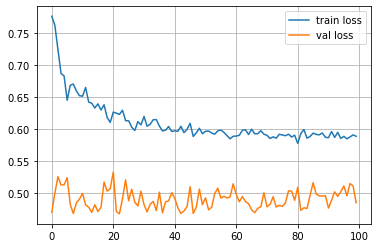

In [464]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_LSTM_AE_REG,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=128,
    num_epochs_=num_epochs,
    lr_=lr,
    lambda_=0.1,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.savefig("loss.svg")
plt.show() 

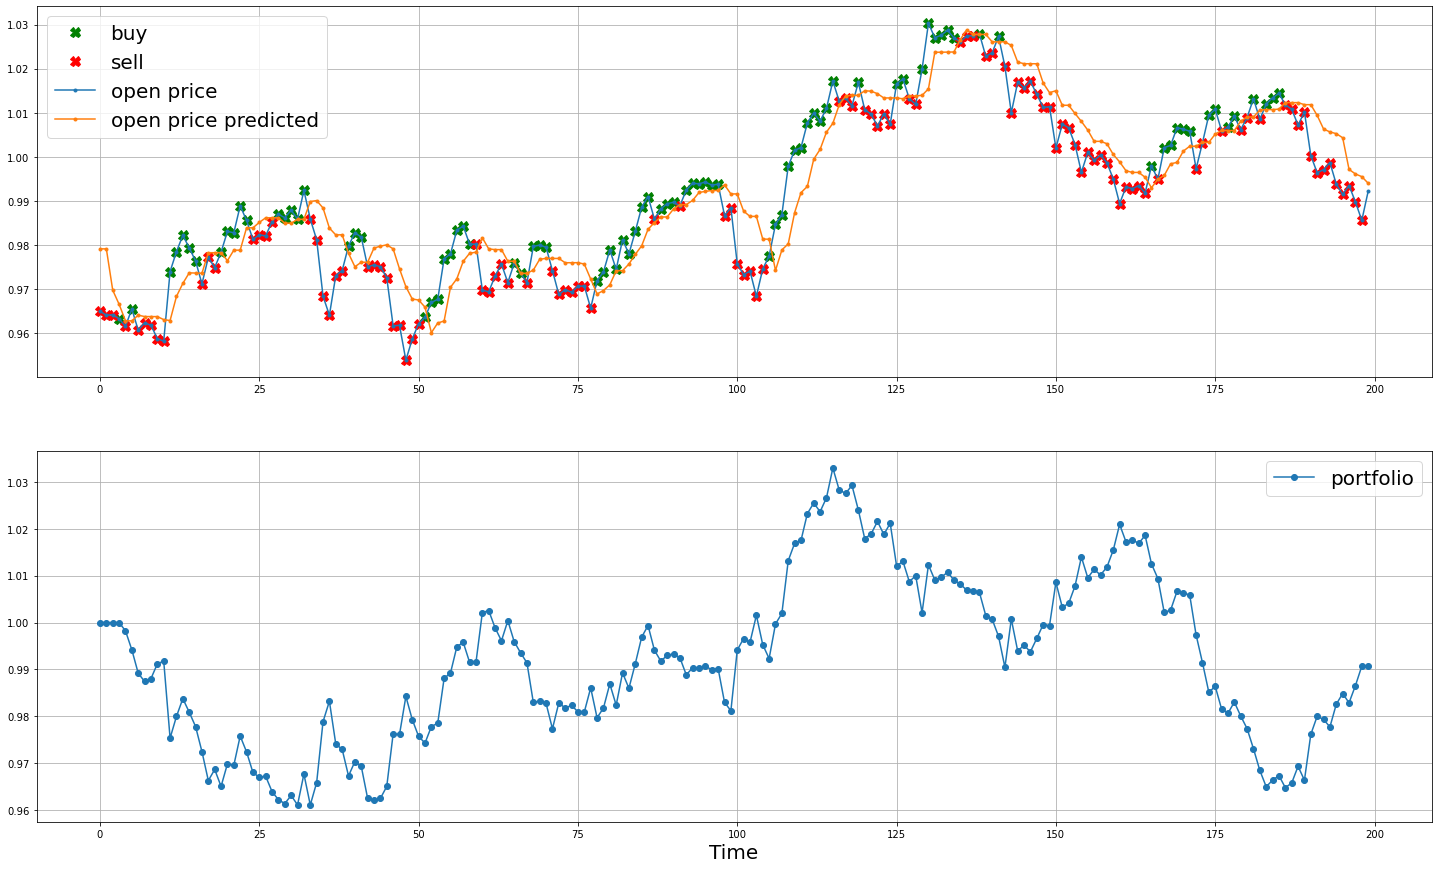

gain = -0.93%


MSE           0.000175
ACC           0.522175
MEAN RET %   -0.003634
Name: LSTM_AE_REG, dtype: float64

In [467]:
outputs_LSTM_AE_REG, targets, MSE = pl.evaluate(model_LSTM_AE_REG, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM_AE_REG = pp.min_max_norm_inverse(outputs_LSTM_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM_AE_REG = np.mean((outputs_LSTM_AE_REG-t)**2)
ACC_LSTM_AE_REG = pl.direction_accuracy(outputs_LSTM_AE_REG, t)
MEAN_RET_LSTM_AE_REG = pl.evauate_strategy(t, outputs_LSTM_AE_REG,start=300, end=700, plot=True, tax=1)

result_price_df['LSTM_AE_REG'] = [MSE_LSTM_AE_REG, ACC_LSTM_AE_REG, MEAN_RET_LSTM_AE_REG]
result_price_df['LSTM_AE_REG']

##### GRU + AE + REG

In [322]:
model_GRU_AE_REG = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.01,
        device=device)
model_GRU_AE_REG.to(device)
model_GRU_AE_REG

GRU_base(
  (gru): GRU(36, 32, num_layers=2, batch_first=True, dropout=0.01)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 10%|█         | 100/1000 [00:17<02:40,  5.59it/s]


0.6726847304192143 < 0.6779392992102582
Epoch: 101/1000
MSE = [train loss mean :  645.36490248] , [val loss mean:  0.66472106, MSE (last) 22772.77832%]


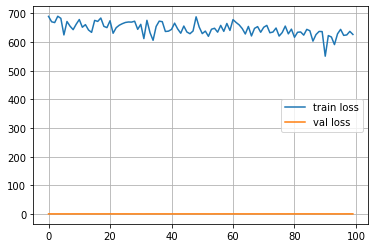

In [327]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_GRU_AE_REG,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=128,
    num_epochs_=num_epochs,
    lr_=lr,
    lambda_=1000,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

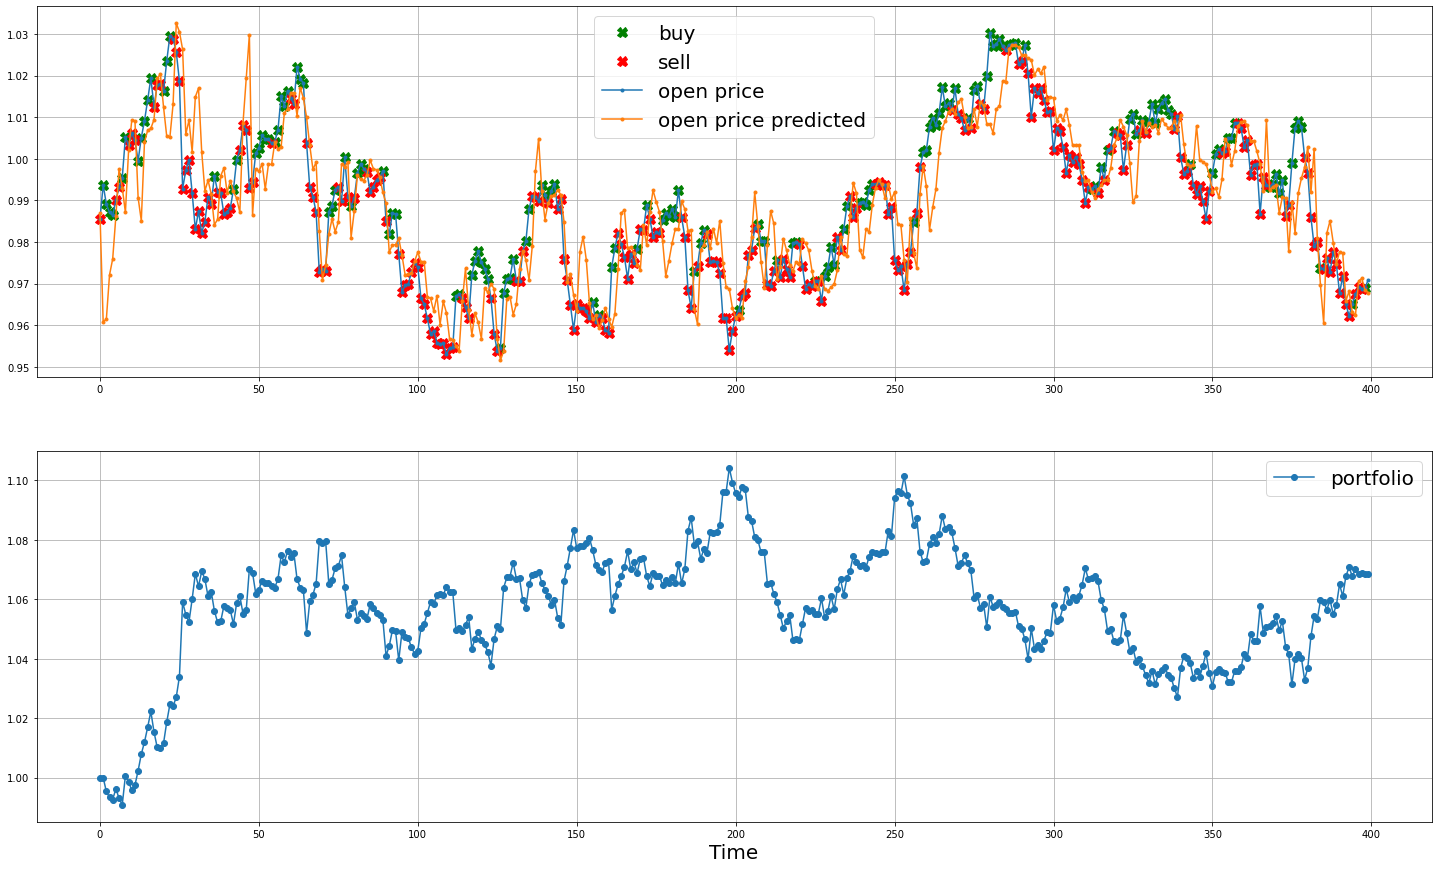

gain = 6.86%


MSE           0.000176
ACC           0.506438
MEAN RET %    0.017760
Name: GRU_AE_REG, dtype: float64

In [336]:
outputs_GRU_AE_REG, targets, MSE = pl.evaluate(model_GRU_AE_REG, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU_AE_REG = pp.min_max_norm_inverse(outputs_GRU_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU_AE_REG = np.mean((outputs_GRU_AE_REG-t)**2)
ACC_GRU_AE_REG = pl.direction_accuracy(outputs_GRU_AE_REG, t)
MEAN_RET_GRU_AE_REG = pl.evauate_strategy(t, outputs_GRU_AE_REG,start=300, end=700, plot=True, tax=1)

result_price_df['GRU_AE_REG'] = [MSE_GRU_AE_REG, ACC_GRU_AE_REG, MEAN_RET_GRU_AE_REG]
result_price_df['GRU_AE_REG']

### Trend prediction

#### Baseline

##### Dense 

In [253]:
model_Dense_Trend = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_Trend.to(device)
model_Dense_Trend

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 10%|█         | 101/1000 [00:18<02:43,  5.51it/s]


0.5375242030620575 < 0.5384151768684388
Epoch: 102/1000
MSE = [train loss mean :  0.57329140] , [val loss mean:  0.59128773, MSE (last) 55.46035%]


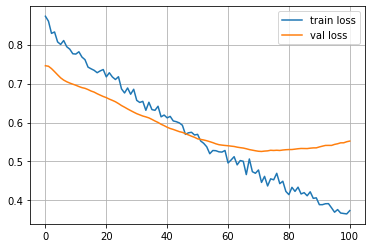

In [254]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_Trend,
    train_x_ = train_x.reshape(train_x.shape[0],-1),
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x.reshape(val_x.shape[0],-1),
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

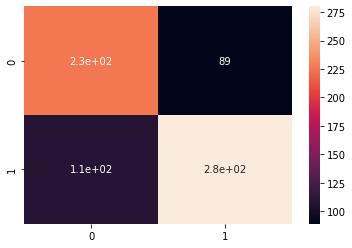

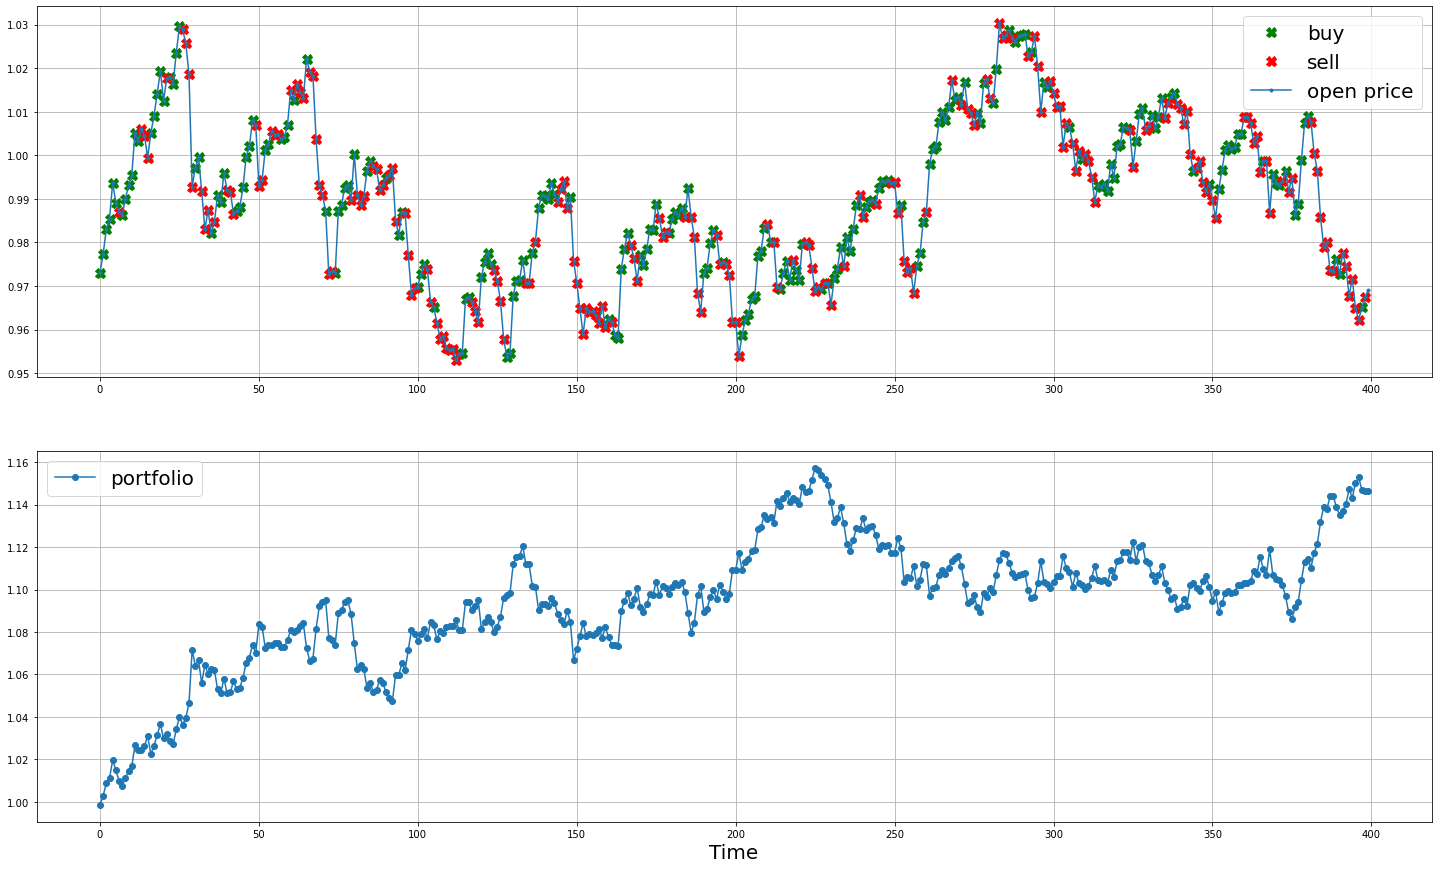

ACC           0.719772
MEAN RET %    0.035988
Name: Dense, dtype: float64

In [255]:
outputs_Dense_Trend, targets, ACC_Dense_Trend = pl.evaluate_trend(model_Dense_Trend, test_x.reshape(test_x.shape[0],-1), test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_Dense_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0], tuple_min_max_=tuple_min_max)

MEAN_RET_Dense_Trend = pl.evauate_strategy_trend(t, outputs_Dense_Trend,plot=True)

result_trend_df['Dense'] = [ACC_Dense_Trend, MEAN_RET_Dense_Trend]
result_trend_df['Dense']

##### LSTM

In [409]:
model_LSTM_Trend = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.35,
        device=device)
model_LSTM_Trend.to(device)
model_LSTM_Trend

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.35)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 14%|█▎        | 136/1000 [00:08<00:56, 15.39it/s]


0.7680118429660797 < 0.768067455291748
Epoch: 137/1000
MSE = [train loss mean :  0.78468476] , [val loss mean:  0.78417187, MSE (last) 76.73659%]


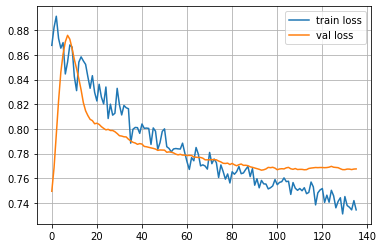

In [410]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_Trend,
    train_x_ = train_x,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

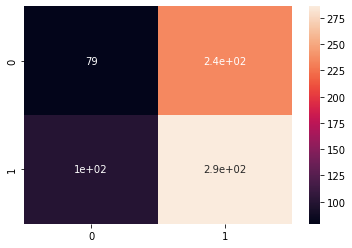

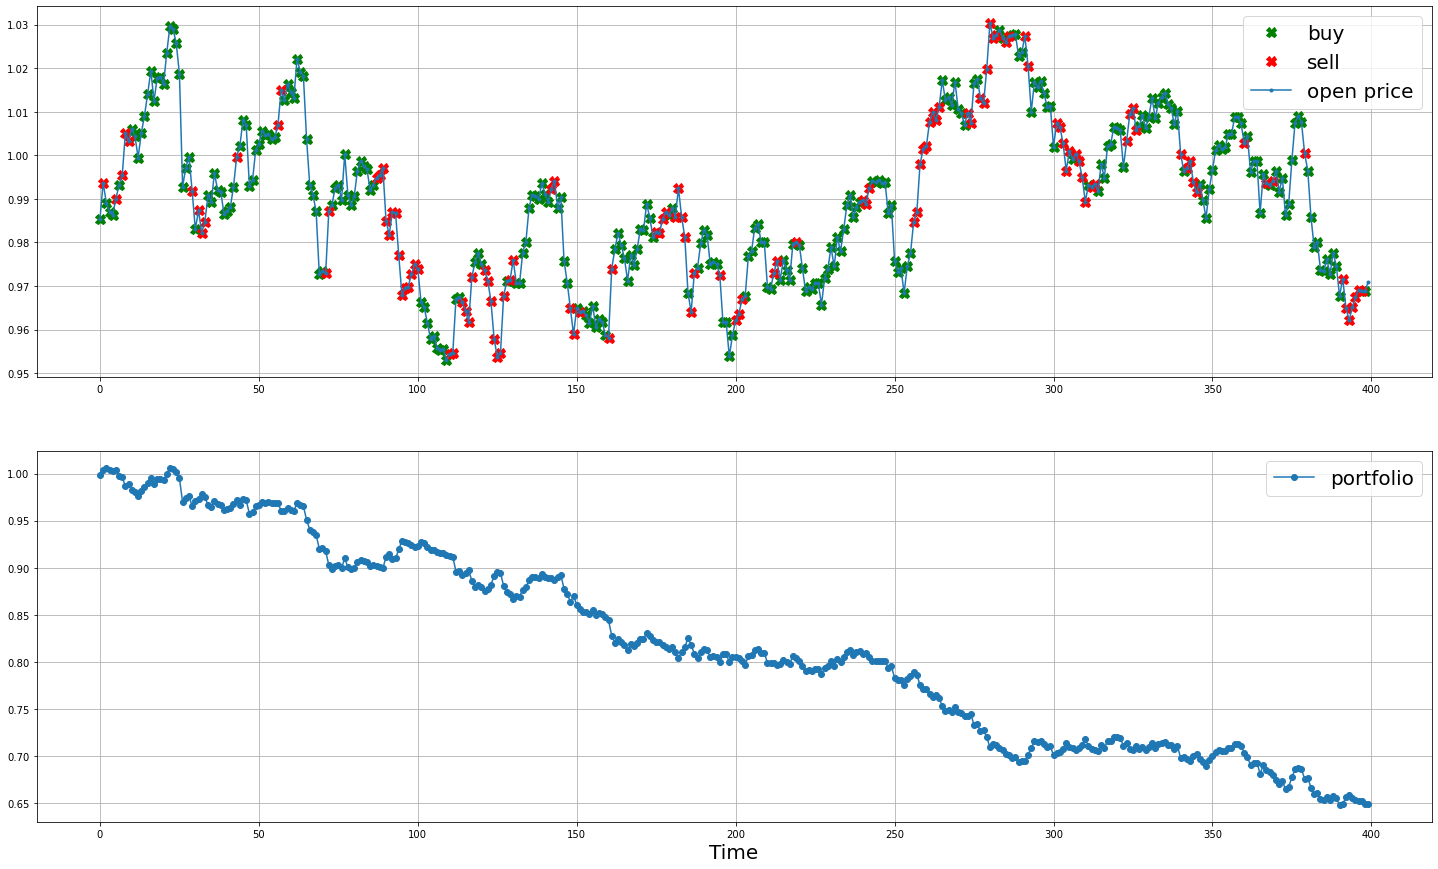

ACC           0.521429
MEAN RET %   -0.105800
Name: LSTM, dtype: float64

In [411]:
outputs_LSTM_Trend, targets, ACC_LSTM_Trend = pl.evaluate_trend(model_LSTM_Trend, test_x, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_LSTM_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_LSTM_Trend = pl.evauate_strategy_trend(t, outputs_LSTM_Trend,plot=True)

result_trend_df['LSTM'] = [ACC_LSTM_Trend, MEAN_RET_LSTM_Trend]
result_trend_df['LSTM']

##### GRU

In [259]:
model_GRU_Trend = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU_Trend.to(device)
model_GRU_Trend

GRU_base(
  (gru): GRU(34, 32, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 16%|█▋        | 164/1000 [00:19<01:41,  8.28it/s]


0.4977752834558487 < 0.4977793180942535
Epoch: 165/1000
MSE = [train loss mean :  0.45168658] , [val loss mean:  0.51398653, MSE (last) 49.75675%]


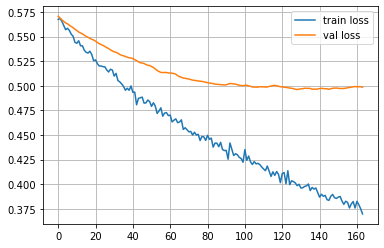

In [261]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_Trend,
    train_x_ = train_x,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

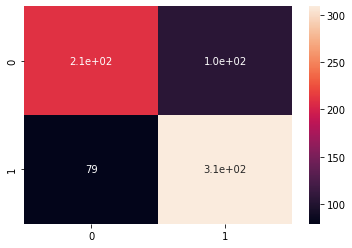

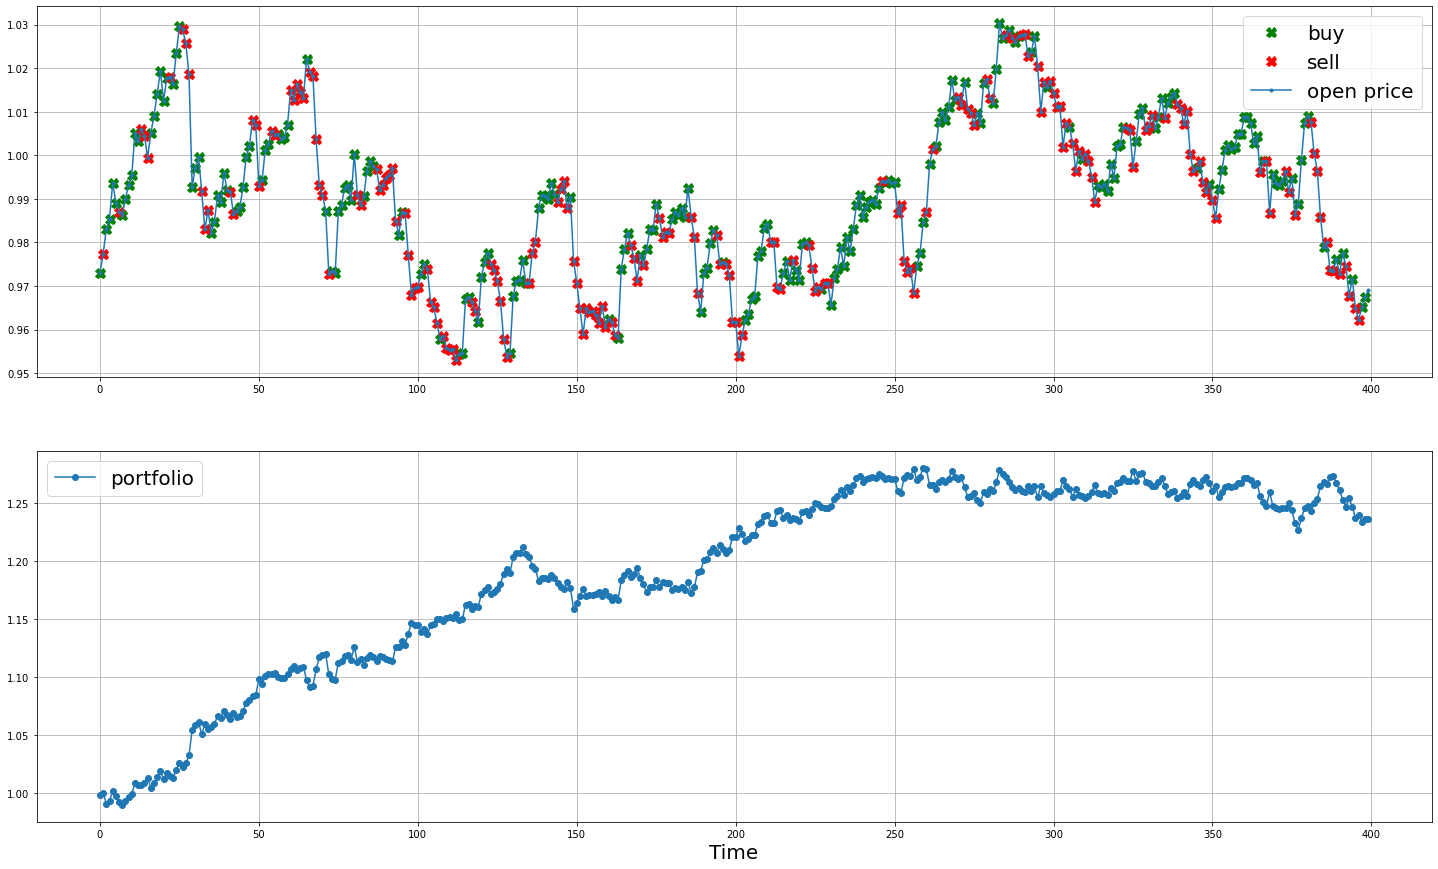

ACC           0.738265
MEAN RET %    0.054765
Name: GRU, dtype: float64

In [262]:
outputs_GRU_Trend, targets, ACC_GRU_Trend = pl.evaluate_trend(model_GRU_Trend, test_x, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_GRU_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_GRU_Trend = pl.evauate_strategy_trend(t, outputs_GRU_Trend, plot=True)

result_trend_df['GRU'] = [ACC_GRU_Trend, MEAN_RET_GRU_Trend]
result_trend_df['GRU']

#### Add Auto-Encoder 

##### Dense + AE

In [263]:
model_Dense_AE_Trend = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_AE_Trend.to(device)
model_Dense_AE_Trend

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

  9%|▉         | 90/1000 [00:14<02:24,  6.31it/s]


0.634576096534729 < 0.6346562123298645
Epoch: 91/1000
MSE = [train loss mean :  0.69163251] , [val loss mean:  0.64757008, MSE (last) 63.74630%]


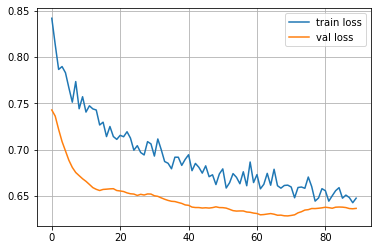

In [264]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_AE_Trend,
    train_x_ = train_x_smooth.reshape(train_x.shape[0],-1),
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x.shape[0],-1),
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

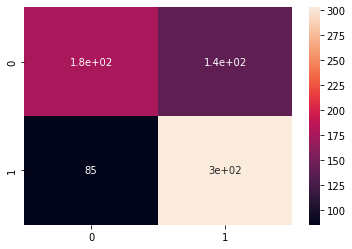

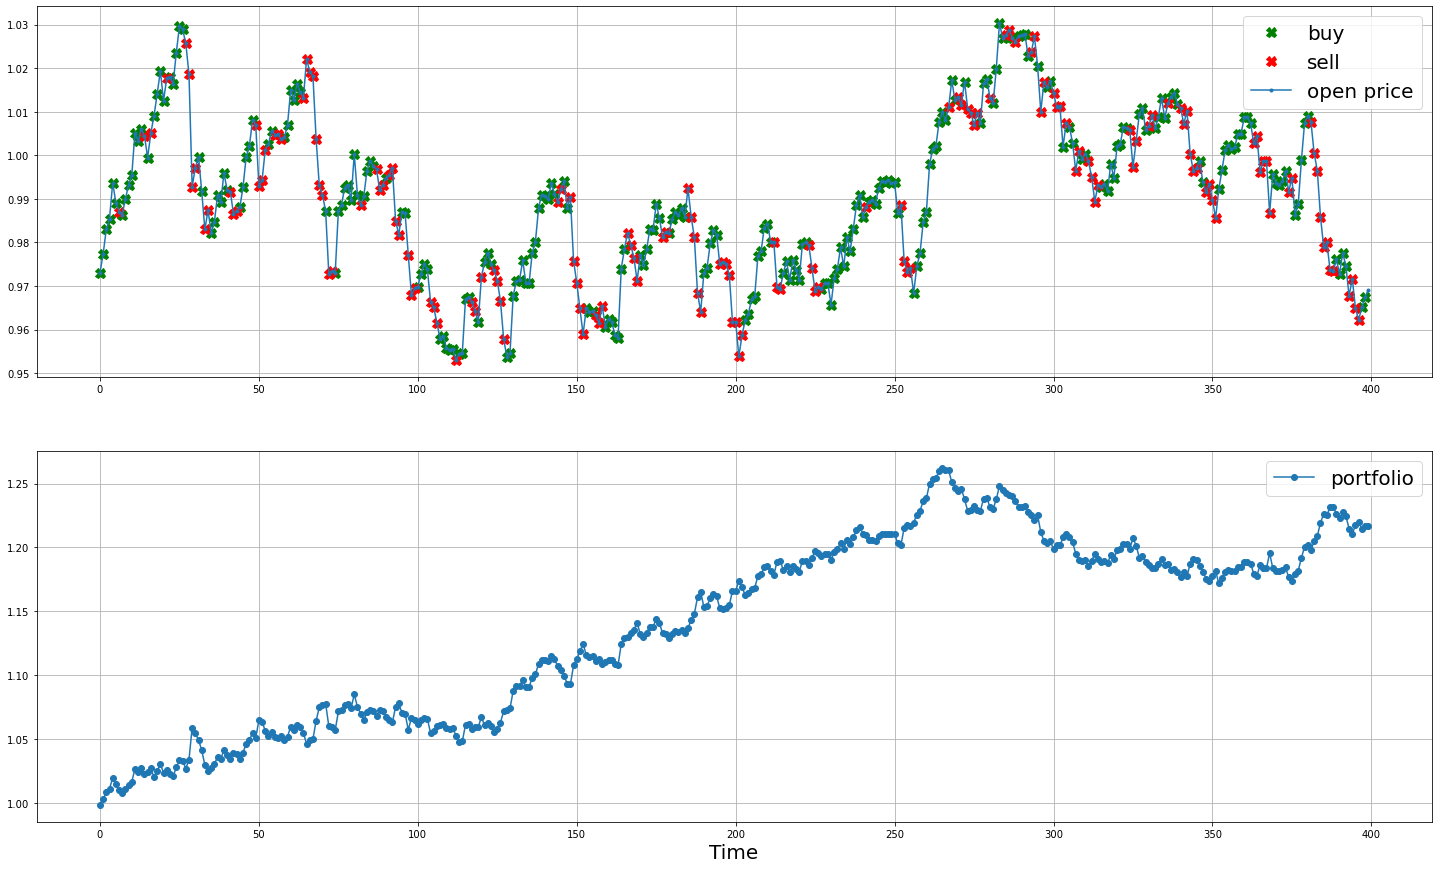

ACC           0.681366
MEAN RET %    0.050708
Name: Dense_AE, dtype: float64

In [265]:
outputs_Dense_AE_Trend, targets, ACC_Dense_AE_Trend = pl.evaluate_trend(model_Dense_AE_Trend, test_x_smooth.reshape(test_x.shape[0],-1), test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_Dense_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0], tuple_min_max_=tuple_min_max)

MEAN_RET_Dense_AE_Trend = pl.evauate_strategy_trend(t, outputs_Dense_AE_Trend,plot=True)

result_trend_df['Dense_AE'] = [ACC_Dense_AE_Trend, MEAN_RET_Dense_AE_Trend]
result_trend_df['Dense_AE']

##### LSTM + AE

In [393]:
model_LSTM_AE_Trend = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_AE_Trend.to(device)
model_LSTM_AE_Trend

LSTM_base(
  (lstm): LSTM(36, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

  7%|▋         | 73/1000 [00:09<02:06,  7.34it/s]


0.7613700687885284 < 0.76145423412323
Epoch: 74/1000
MSE = [train loss mean :  0.74517912] , [val loss mean:  0.76349133, MSE (last) 76.37053%]


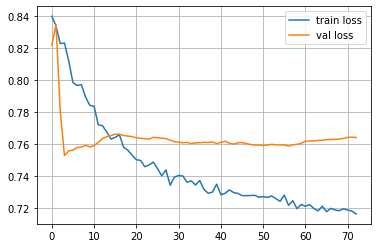

In [394]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_AE_Trend,
    train_x_ = train_x_smooth,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=128,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize) , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize) , label="val loss")
plt.legend()
plt.grid()
plt.show() 

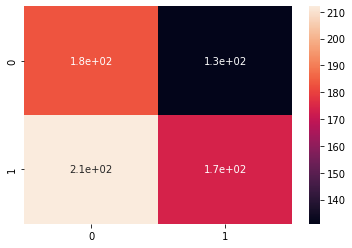

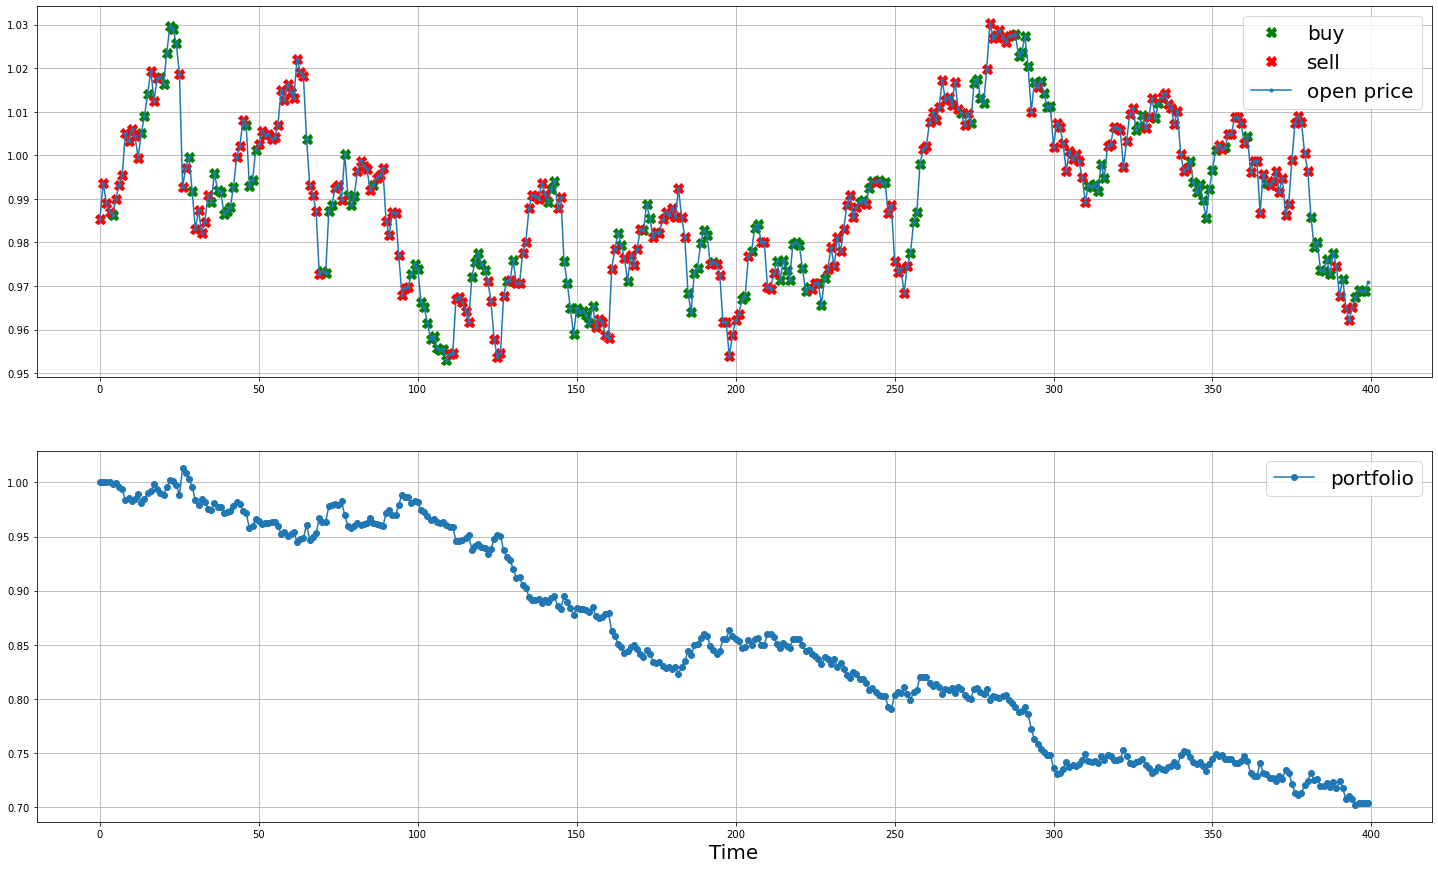

ACC           0.510000
MEAN RET %   -0.086216
Name: LSTM_AE, dtype: float64

In [395]:
outputs_LSTM_AE_Trend, targets, ACC_LSTM_AE_Trend = pl.evaluate_trend(model_LSTM_AE_Trend, test_x_smooth, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_LSTM_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_LSTM_AE_Trend = pl.evauate_strategy_trend(t, outputs_LSTM_AE_Trend,plot=True)

result_trend_df['LSTM_AE'] = [ACC_LSTM_AE_Trend, MEAN_RET_LSTM_AE_Trend]
result_trend_df['LSTM_AE']

##### GRU + AE

In [401]:
model_GRU_AE_Trend = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.45,
        device=device)
model_GRU_AE_Trend.to(device)
model_GRU_AE_Trend

GRU_base(
  (gru): GRU(36, 32, num_layers=2, batch_first=True, dropout=0.45)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

  5%|▌         | 51/1000 [00:05<01:38,  9.67it/s]


0.7489868772029876 < 0.7522952342033387
Epoch: 52/1000
MSE = [train loss mean :  0.82004058] , [val loss mean:  0.74886452, MSE (last) 75.49697%]


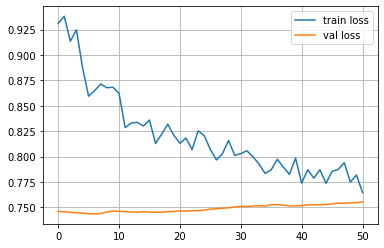

In [402]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_AE_Trend,
    train_x_ = train_x_smooth,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= 1
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize), label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize), label="val loss")
plt.legend()
plt.grid()
plt.show() 

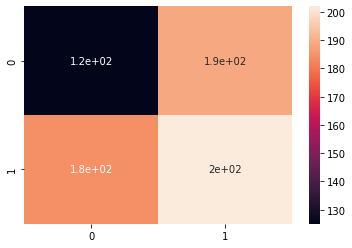

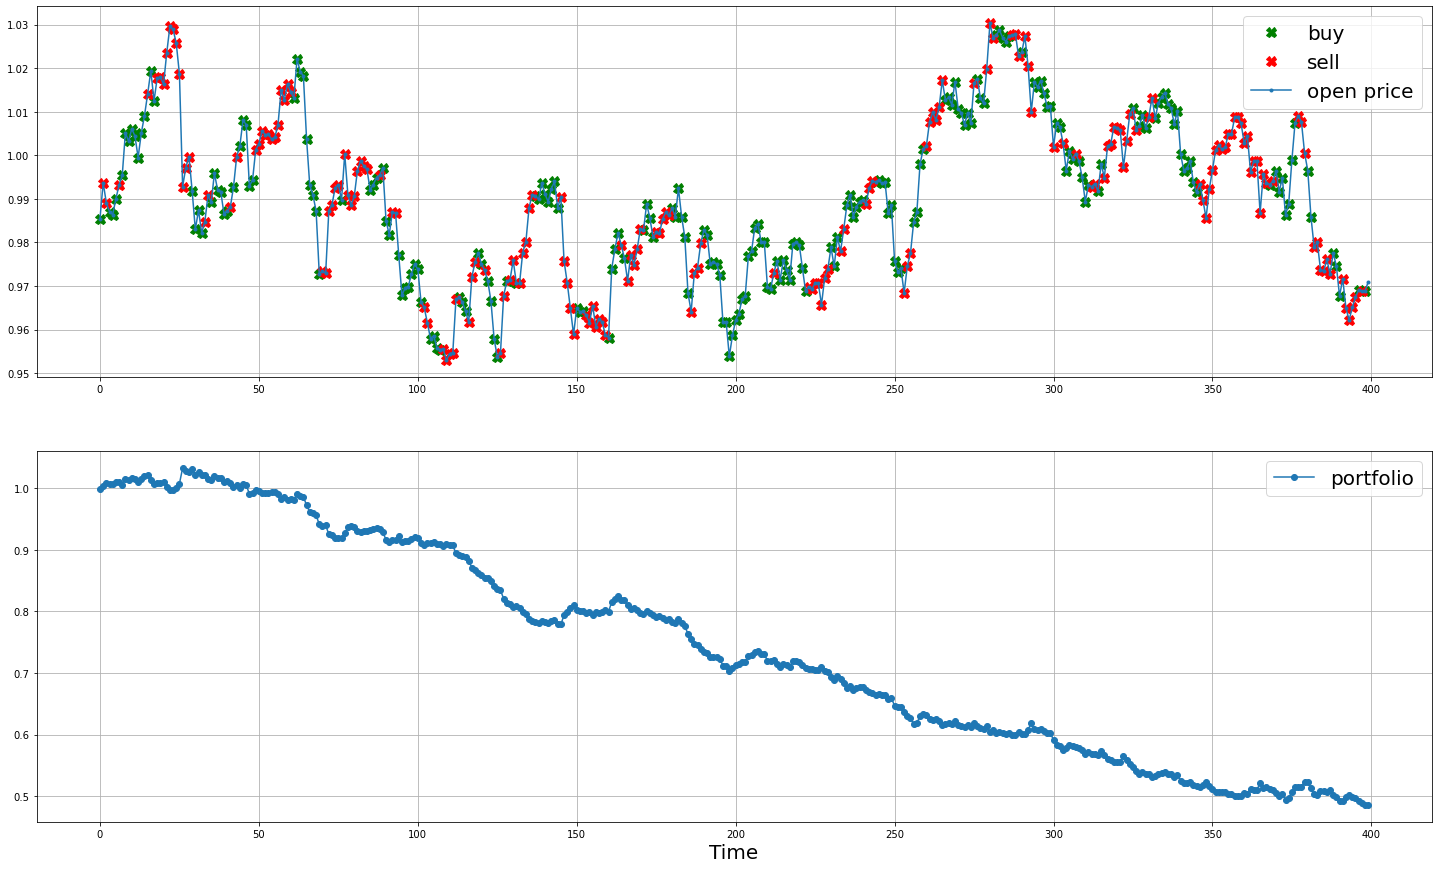

ACC           0.467143
MEAN RET %   -0.177727
Name: GRU_AE, dtype: float64

In [403]:
outputs_GRU_AE_Trend, targets, ACC_GRU_AE_Trend = pl.evaluate_trend(model_GRU_AE_Trend, test_x_smooth, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_GRU_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_GRU_AE_Trend = pl.evauate_strategy_trend(t, outputs_GRU_AE_Trend, plot=True)

result_trend_df['GRU_AE'] = [ACC_GRU_AE_Trend, MEAN_RET_GRU_AE_Trend]
result_trend_df['GRU_AE']

## Result 

### Price

In [252]:
result_price_df.head()

Dense      LSTM       GRU  Dense_AE   LSTM_AE    GRU_AE  \
MSE         0.000092  0.000091  0.000171  0.000132  0.000134  0.000137   
ACC         0.668091  0.700855  0.716524  0.675214  0.696581  0.692308   
MEAN RET %  0.080301  0.109321  0.110061  0.114876  0.123489  0.109935   

            Dense_AE_REG  LSTM_AE_REG  GRU_AE_REG  
MSE             0.000120     0.000136    0.000119  
ACC             0.650997     0.680912    0.670940  
MEAN RET %      0.104628     0.113069    0.100606

### Trend 

In [273]:
result_trend_df.head()

Dense      LSTM       GRU  Dense_AE   LSTM_AE    GRU_AE
ACC         0.719772  0.761024  0.738265  0.681366  0.682788  0.681366
MEAN RET %  0.035988  0.056022  0.054765  0.050708  0.070059  0.054781